Submitted by:
1. Natan Izhak Poor 211412986
2. Liraz Lizi Cohen 318865854
3. Khaled Khalaf 207966607
Submission date: 12/08/2024

Introduction:
This is a network analysis project about a shared bicycles network in Chicago. The data was provided by Divvy which is the company that runs the network and it represents trips that customers did using Divvy's rented bicycles.
We are going to use random graphs models such as Watts-Strogatz and Erdos-Renyi to find out if our network is a special kind (scale-free, small-world, etc.), then we'll test different hypotheses using different methods, and create a special model that suggests where to place new stations, according to the results of our hypotheses.

Let's dive in!

Install necessary libraries

In [1]:
!pip install pandas networkx openpyxl matplotlib folium shapely seaborn statsmodels python-louvain pyvis cdlib scikit-learn-extra numpy
!pip install scikit-learn ipython powerlaw requests


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import necessary libraries

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from scipy.stats import pearsonr, spearmanr
import random
import json
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
import numpy as np
from IPython.display import display, IFrame
import community.community_louvain as community_louvain
from sklearn.cluster import SpectralClustering, KMeans
from networkx.algorithms.community.quality import modularity
import statistics
from networkx.algorithms.community import girvan_newman
import itertools
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn_extra.cluster import KMedoids
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
import powerlaw
import seaborn as sns
import scipy.stats as stats
import requests
import os

Let's first load ALL the data of the networks from our excel files - DivvyTripsByQuarter.xlsx and DivvyTripsReady.xlsx. We'll also drop all the unnecessary columns here.
Note: This data is ready after this cell since it went through our pre-processing in which we've added all the necessary data. The pre-processing notebook is also attached in the projects files.
If getting the data failes (for any reason...) we'll clone it and read locally. This code was added as a "just in case".

In [3]:
try:
    dfQ1 = pd.read_excel('https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsByQuarter.xlsx', sheet_name='Q1')
    dfQ2 = pd.read_excel('https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsByQuarter.xlsx', sheet_name='Q2')
    dfQ3 = pd.read_excel('https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsByQuarter2.xlsx', sheet_name='Q3')
    dfQ4 = pd.read_excel('https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsByQuarter2.xlsx', sheet_name='Q4')
    dfQ1 = dfQ1.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    dfQ2 = dfQ2.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    dfQ3 = dfQ3.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    dfQ4 = dfQ4.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    df_tmp = pd.read_excel('https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsReady.xlsx')
    df_tmp2 = pd.read_excel('https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsReady2.xlsx')
    dfAll = pd.concat([df_tmp, df_tmp2], ignore_index=True)
    dfAll = dfAll.drop(['GENDER', 'BIRTH YEAR'], axis=1)
except:
    if not os.path.isdir('DivvyTripsData'):
        !git clone https://github.com/NatiIPReact/DivvyTripsData
    dfQ1 = pd.read_excel('DivvyTripsData/DivvyTripsByQuarter.xlsx', sheet_name='Q1')
    dfQ2 = pd.read_excel('DivvyTripsData/DivvyTripsByQuarter.xlsx', sheet_name='Q2')
    dfQ3 = pd.read_excel('DivvyTripsData/DivvyTripsByQuarter2.xlsx', sheet_name='Q3')
    dfQ4 = pd.read_excel('DivvyTripsData/DivvyTripsByQuarter2.xlsx', sheet_name='Q4')
    dfQ1 = dfQ1.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    dfQ2 = dfQ2.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    dfQ3 = dfQ3.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    dfQ4 = dfQ4.drop(['GENDER', 'BIRTH YEAR'], axis=1)
    df_tmp = pd.read_excel('DivvyTripsData/DivvyTripsReady.xlsx')
    df_tmp2 = pd.read_excel('DivvyTripsData/DivvyTripsReady2.xlsx')
    dfAll = pd.concat([df_tmp, df_tmp2], ignore_index=True)
    dfAll = dfAll.drop(['GENDER', 'BIRTH YEAR'], axis=1)

Now let's build all the five networks (one for each quarter, and one that contains all the data combied - 5 networks in total)
We've implemented a function that reads the excel file and builds a network using its data. It adds all necessary attributes to the network's nodes and edges and returns the completed network.

In [4]:
def create_weighted_graph(df):
    """Create a directed graph with edge weights and additional attributes based on the DataFrame."""
    # Create a weighted graph from the DataFrame
    df_weighted = df.groupby(['source', 'target']).size().reset_index(name='weight')
    G = nx.from_pandas_edgelist(df_weighted, 'source', 'target', create_using=nx.DiGraph(), edge_attr=True)
    
    # Initialize the "USER TYPE" attribute for edges
    for u, v, d in G.edges(data=True):
        d['user_types'] = []
    
    # Add additional attributes to the nodes
    for index, row in df.iterrows():
        # Adding attributes for the source node
        G.nodes[row['source']].update({
            'Area': row['SourceArea'],
            'MedianIncome': row['SourceMedianIncome'],
            'Latitude': row['FROM LATITUDE'],
            'Longitude': row['FROM LONGITUDE'],
            'ProximityIndex': row['SourceProximityIndex']
        })
        
        # Adding attributes for the target node
        G.nodes[row['target']].update({
            'Area': row['TargetArea'],
            'MedianIncome': row['TargetMedianIncome'],
            'Latitude': row['TO LATITUDE'],
            'Longitude': row['TO LONGITUDE'],
            'ProximityIndex': row['TargetProximityIndex']
        })
        
        # Adding "USER TYPE" attribute to the edges
        if G.has_edge(row['source'], row['target']):
            G[row['source']][row['target']]['user_types'].append(row['USER TYPE'])
    
    return G

# Create weighted graphs for each quarter
GQ1 = create_weighted_graph(dfQ1)
GQ2 = create_weighted_graph(dfQ2)
GQ3 = create_weighted_graph(dfQ3)
GQ4 = create_weighted_graph(dfQ4)
GALL = create_weighted_graph(dfAll)

Now the first thing we would like to do is to plot the network's degree distribution, we'll use the GALL network for this which includes all the trips data together. (Both regular and in log log scale), average clustering coefficient, average path length, and its largest connected component (giant). Then we'll use these results to see whether we have a network which is one of the models we've learnt (Small-World, Scale-Free, etc.)
We are doing everything through functions to use it later again in an easier way.

Average Clustering Coefficient: 0.6940942381286819
Average Path Length: 1.5419479267116682
Largest Connected Component Size: 306


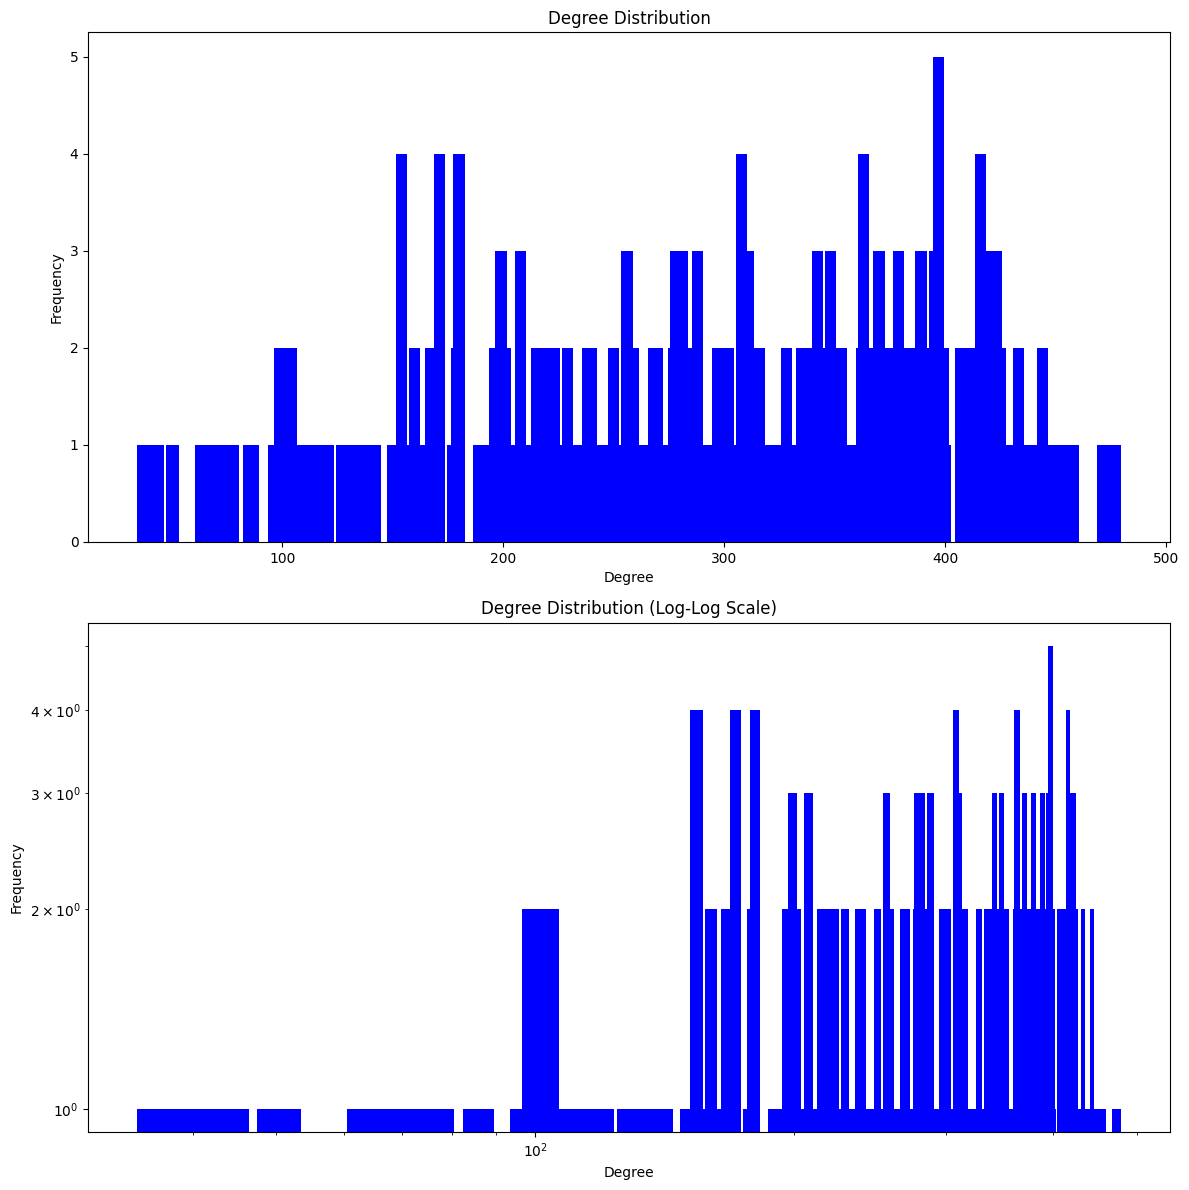

In [5]:
# Define the plotting function with bar charts and larger bars
def plot_degree_distribution_bar(G):
    degrees = [G.degree(n) for n in G.nodes()]
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    
    plt.figure(figsize=(12, 12))

    # Regular scale
    plt.subplot(211)
    plt.bar(unique_degrees, counts, color='b', width=5.0)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution')

    # Log-log scale
    plt.subplot(212)
    plt.bar(unique_degrees, counts, color='b', width=5.0)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution (Log-Log Scale)')

    plt.tight_layout()
    plt.show()

# Average Clustering Coefficient
def average_clustering_coefficient(G):
    return nx.average_clustering(G)

# Average Path Length
def average_path_length(G):
    try:
        return nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        return None  # Return None if the graph is not connected

# Largest Connected Component
def largest_connected_component(G):
    if nx.is_directed(G):
        G = G.to_undirected()

    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    return G_lcc

avg_clustering_coefficient = average_clustering_coefficient(GALL)
avg_path_length = average_path_length(GALL)
G_lcc = largest_connected_component(GALL)

# Print results
print(f"Average Clustering Coefficient: {avg_clustering_coefficient}")
print(f"Average Path Length: {avg_path_length}")
print(f"Largest Connected Component Size: {len(G_lcc)}")

# Apply functions to GALL
plot_degree_distribution_bar(GALL)

As we can see, the degree distribution doesn't look like a bell distribution but doesn't look like a power-law either.
Now let's use the ER model to create a random graph and plot its values, so we'll be able to compare between them.

We'll use:
n = Number of nodes in GALL
p = k/(n-1)
As we've seen in the lectures.

p = 0.46871316832744025
Average Clustering Coefficient: 0.4681761325445906
Average Path Length: 1.5320582877959927
Largest Connected Component Size: 306


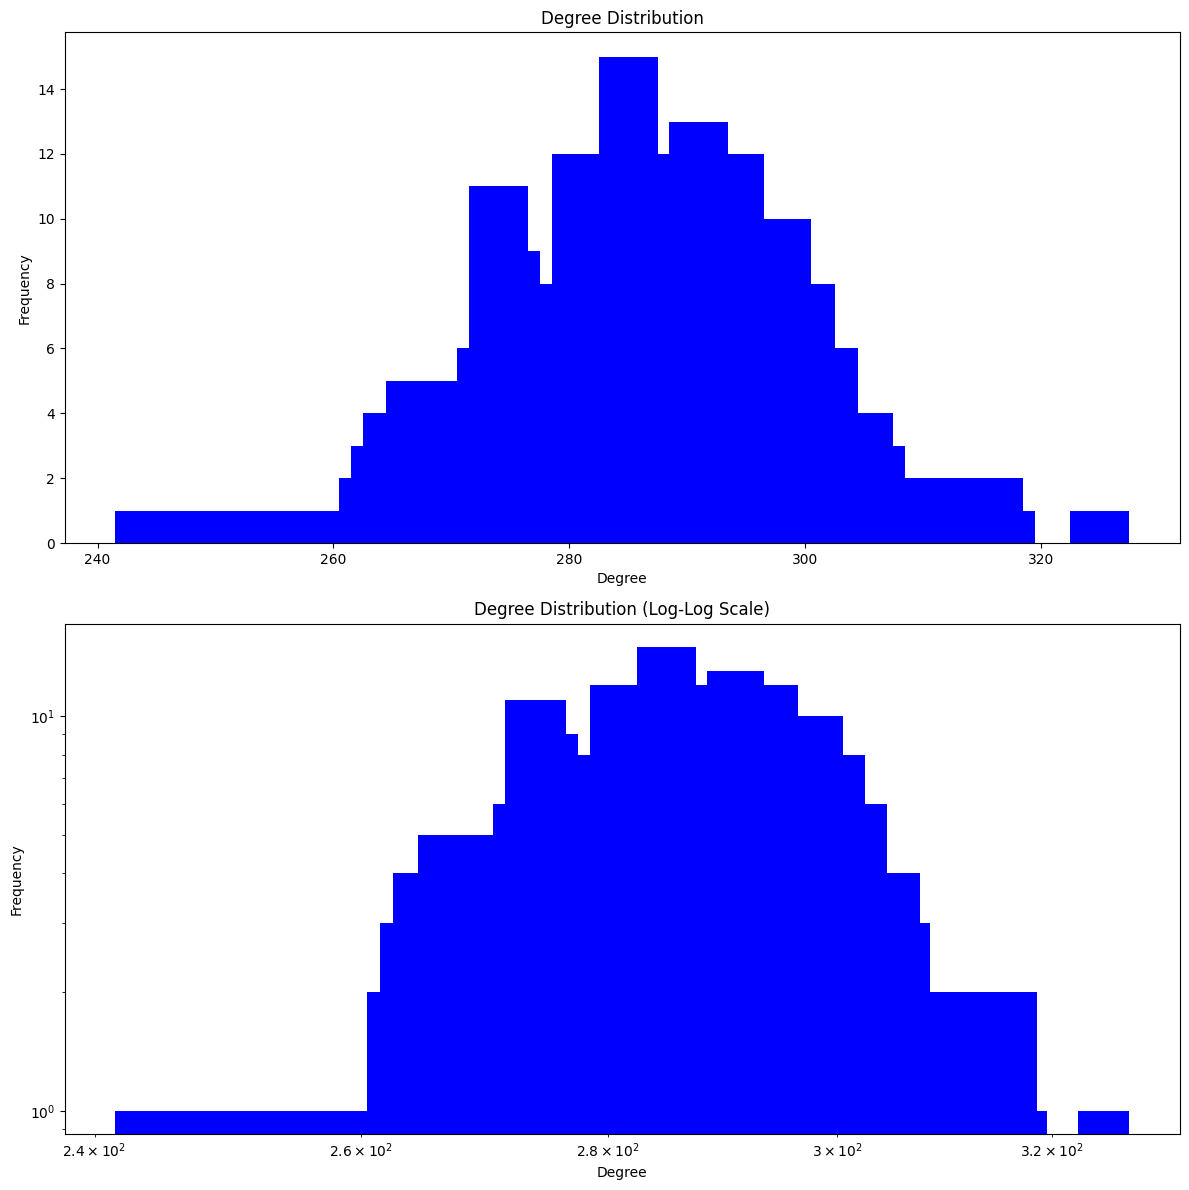

In [6]:
n = GALL.number_of_nodes()
total_out_degree = sum(dict(GALL.out_degree()).values())
k = total_out_degree / n
# Calculate p using p = k / (n-1)
p = k / (n - 1)
GRandom = nx.erdos_renyi_graph(n, p, directed=True)

ER_avg_clustering_coefficient = average_clustering_coefficient(GRandom)
ER_avg_path_length = average_path_length(GRandom)
ER_G_lcc = largest_connected_component(GRandom)
# Print results
print('p =', p)
print(f"Average Clustering Coefficient: {ER_avg_clustering_coefficient}")
print(f"Average Path Length: {ER_avg_path_length}")
print(f"Largest Connected Component Size: {len(ER_G_lcc)}")
plot_degree_distribution_bar(GRandom)

As expected, we clearly got a bell-like degree distribution.

Now let's use the WS method which generates a "small-world" network to check its values against our network

Average Clustering Coefficient: 0.565431228398566
Average Path Length: 1.7796207007393121
Largest Connected Component Size: 306


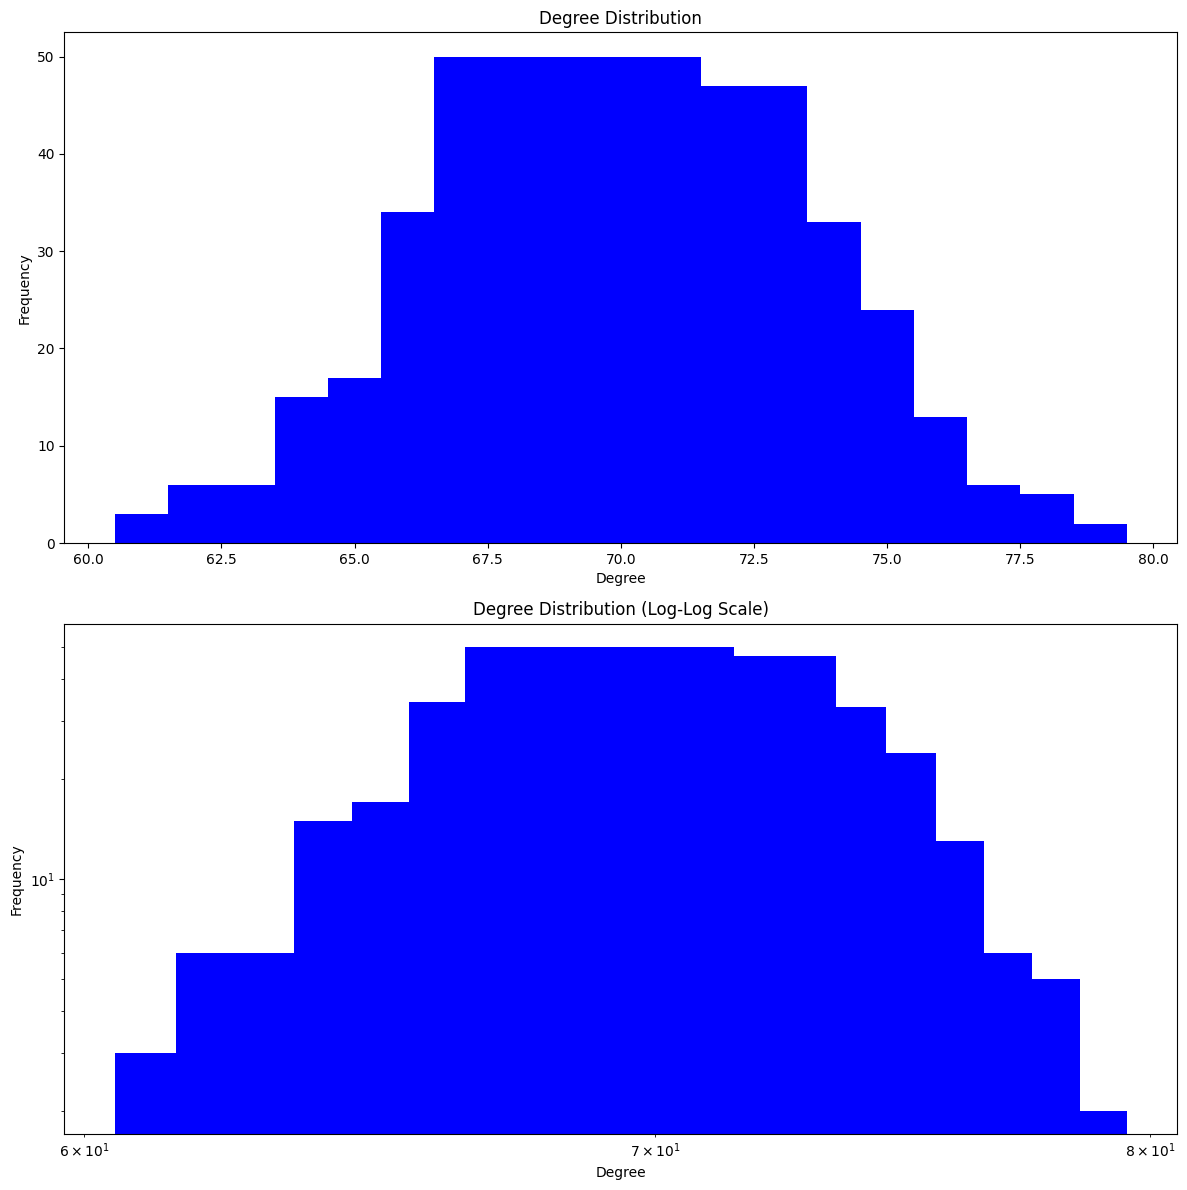

In [7]:
# Parameters for Watts-Strogatz model
beta = 0.1  # Rewiring probability
# Generate a Watts-Strogatz small-world network
G_ws = nx.watts_strogatz_graph(int(n), int(k // 2), beta)  # k should be even, so use k // 2 for neighbors on each side
WS_avg_clustering_coefficient = average_clustering_coefficient(G_ws)
WS_avg_path_length = average_path_length(G_ws)
WS_G_lcc = largest_connected_component(G_ws)
# Print results
print(f"Average Clustering Coefficient: {WS_avg_clustering_coefficient}")
print(f"Average Path Length: {WS_avg_path_length}")
print(f"Largest Connected Component Size: {len(WS_G_lcc)}")
plot_degree_distribution_bar(G_ws)

Again, we clearly got a bell-like degree distribution.
Let's plot the metric's results in a bar chart

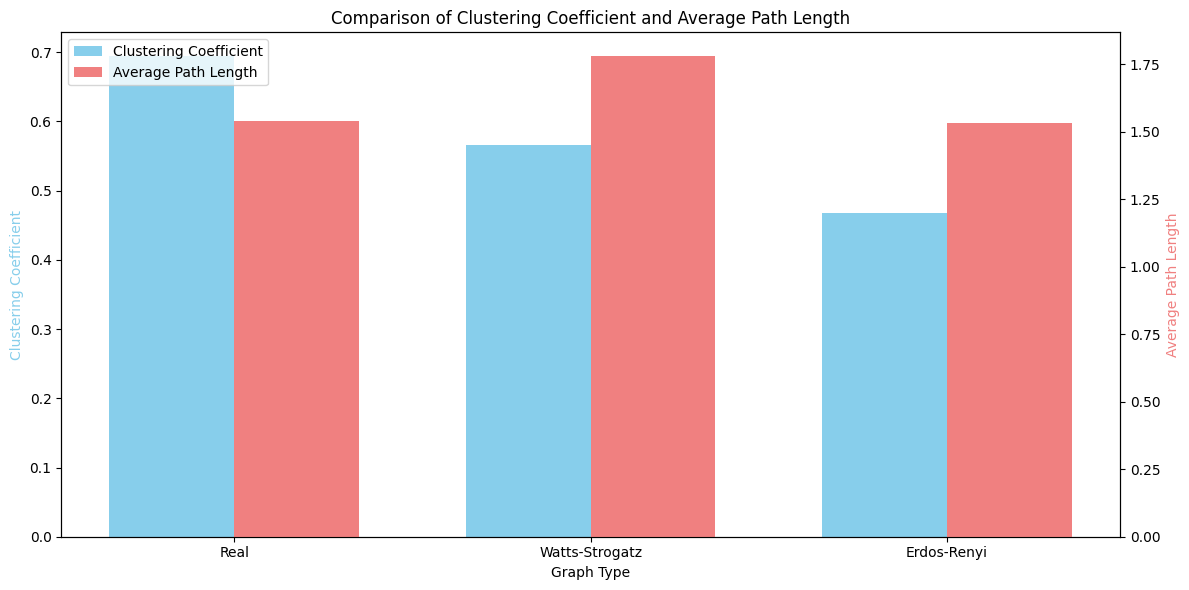

In [8]:
labels = ['Real', 'Watts-Strogatz', 'Erdos-Renyi']
clustering_coeffs = [avg_clustering_coefficient, WS_avg_clustering_coefficient, ER_avg_clustering_coefficient]
avg_path_lengths = [avg_path_length, WS_avg_path_length, ER_avg_path_length]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Clustering coefficient bars
bar1 = ax1.bar(x - width/2, clustering_coeffs, width, label='Clustering Coefficient', color='skyblue')

# Average path length bars
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, avg_path_lengths, width, label='Average Path Length', color='lightcoral')

# Add some text for labels, title, and custom x-axis tick labels
ax1.set_xlabel('Graph Type')
ax1.set_ylabel('Clustering Coefficient', color='skyblue')
ax2.set_ylabel('Average Path Length', color='lightcoral')
ax1.set_title('Comparison of Clustering Coefficient and Average Path Length')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Add legends
bars = [bar1, bar2]
labels = [bar.get_label() for bar in bars if not bar.get_label().startswith('_')]
ax1.legend(bars, labels, loc='upper left')

fig.tight_layout()
plt.show()

As we can see, the real graph has a much higher clustering coefficient than both the WS generated graph and ER generated graph (Even though the WS method is designed to generate small-world networks!).
The real graph's average path length is smaller than the average path length of the WS generated graph and it's around the same value of the ER generated graph.
This means that our network is a small-world model, since in order to be a small-world network you need a higher clustering coefficient and a shorter average path length to the generated graphs.

The first hypothesis we'd like to test is whether stations closest to central places (Universities, big train stations, tourist attractions, etc.) in the city are central stations in the network. To test this hypothesis, we'll check the correlation between the betweenness centrality measure of each node and its corresponding ProximityIndex value which is a [0-1] value that represents how close a station is to important places around the city.
Note: The ProximityIndex value for each node was calculated in the pre-processing file.
We'll calculate both the Pearson correlation (which assumes linear relationship) and Spearman correlation which assumes (which assumes monotonic relationship)

For Pearson correlation:
Null Hypothesis (H0): There is no linear relationship between the two variables 
Alternative Hypothesis (H1): There is a linear relationship between the two variables
For Spearman correlation:
Null Hypothesis (H0):  There is no monotonic relationship between the two variables.
Alternative Hypothesis (H1): There is a monotonic relationship between the two variables.

We'll start with the first quarter. This data represents the following timeframe: June - August 2013

First, let's get a sense of where the stations are around the city, by plotting a heat map of them around Chicago.
Note: chicago_community_boundaries.json is a GeoJSON file of Chicago's boundries we found on Kaggle and its used to show Chicago's boundaries on the heat map. You can see the source of the file in the following link.
https://www.kaggle.com/datasets/kylescissons/city-of-chicago-community-boundaries-geojson

To plot the heat map, we'll first need to get a list of stations and their position (longitude & latitude)

In [9]:
source_stations = dfQ1[['source', 'FROM LATITUDE', 'FROM LONGITUDE']].drop_duplicates()
source_stations.columns = ['station', 'latitude', 'longitude']
target_stations = dfQ1[['target', 'TO LATITUDE', 'TO LONGITUDE']].drop_duplicates()
target_stations.columns = ['station', 'latitude', 'longitude']
all_stations = pd.concat([source_stations, target_stations]).drop_duplicates().reset_index(drop=True)
stations_list = all_stations.to_dict(orient='records')
# Print an example
stations_list[0]

{'station': 'Michigan Ave & Oak St',
 'latitude': 41.90096039,
 'longitude': -87.62377664}

Now let's plot the heat map using the stations data and Chicago's boundries.

Note: You may need to trust this notebook to make this run properly. If so, please press on "Trust Notebook".
This code will also save the map on the notebook's folder as an html file, so if you can't see it here, please open the html file in your folder.
Don't worry, we promise there isn't a code injection attack inside! :)
If getting the boundaries file failes (for any reason...) we'll clone it and read locally. This code was added as a "just in case".

In [10]:
try:
    response = requests.get('https://raw.githubusercontent.com/NatiIPReact/NetworkAlgorithms/main/chicago_community_boundaries.json')
    chicago_boundaries_geojson = response.json()
except:
    if not os.path.isdir('DivvyTripsData'):
        !git clone https://github.com/NatiIPReact/DivvyTripsData
    geojson_file_path = 'DivvyTripsData/chicago_community_boundaries.json'
    with open(geojson_file_path) as f:
        chicago_boundaries_geojson = json.load(f)

# Combine all community boundaries into a single unified polygon
all_boundaries = []
for feature in chicago_boundaries_geojson['features']:
    geom = shape(feature['geometry'])
    all_boundaries.append(geom)

# Create a unified boundary for Chicago using unary_union
chicago_boundary = unary_union(all_boundaries)
chicago_boundary_geojson = mapping(chicago_boundary)

# Convert to a GeoJSON format suitable for folium
chicago_boundary_feature = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": chicago_boundary_geojson,
            "properties": {"name": "Chicago"}
        }
    ]
}

# Create a base map centered around Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Extract latitude and longitude from the stations_list
heat_data = [[station['latitude'], station['longitude']] for station in stations_list]

# Create a heatmap layer
HeatMap(heat_data).add_to(m)

# Add the combined Chicago boundary to the map
folium.GeoJson(chicago_boundary_feature, name='Chicago Boundary').add_to(m)

# Add layer control to toggle between layers
folium.LayerControl().add_to(m)

m.save('chicago_heatmap_q1.html')
display(m)

As we can see, most of the stations are around centeral Chicago (and thus most of the heat is around this area) which helps us believe that the first hypothesis is true. Let's now test it.
To test the hypothesis, we shall calculate the betweenness centrality values of our nodes. We'll also sort them in descending order and print.
We'll then calculate and print both the pearson and spearman correlations.
For the first quarter, we'll do the process manually to see the results, then, we'll define a function that calculates the correlation between the ProximityIndex and the Betweenness Centrality of the nodes.

In [11]:
betweenness_centrality = nx.betweenness_centrality(GQ1)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
sorted_betweenness_centrality

[('Wabash Ave & Roosevelt Rd', 0.02116604163126385),
 ('Millennium Park', 0.01638608638900921),
 ('Clinton St & Madison St', 0.016348014764477756),
 ('Clinton St & Washington Blvd', 0.01454720116996427),
 ('McClurg Ct & Illinois St', 0.014409368269432385),
 ('Lake Shore Dr & Monroe St', 0.01378464850311593),
 ('Daley Center Plaza', 0.012101671246931336),
 ('Museum Campus', 0.011598303535596407),
 ('Franklin St & Jackson Blvd', 0.01149428029453668),
 ('State St & 16th St', 0.011450093900515072),
 ('Congress Pkwy & Ogden Ave', 0.011424704780620814),
 ('Streeter Dr & Illinois St', 0.010773066822441746),
 ('Dearborn St & Adams St', 0.010626749602030285),
 ('State St & Kinzie St', 0.010247116954748007),
 ('Michigan Ave & Oak St', 0.010081377135462314),
 ('State St & Van Buren St', 0.00947735745403094),
 ('Michigan Ave & Lake St', 0.009131387149423013),
 ('Fairbanks Ct & Grand Ave', 0.009020137773918104),
 ('Michigan Ave & Pearson St', 0.00901703060530789),
 ('State St & Randolph St', 0.0084

Now let's get the ProximityIndex value of each node by descending order and print them.

In [12]:
# Start with target stations
unique_stations = dfQ1[['target', 'TargetProximityIndex']].drop_duplicates()
priority_index_dict = dict(zip(unique_stations['target'], unique_stations['TargetProximityIndex']))
# Use source proximity columns for stations that weren't in target atleast once (Stations without any trips to them)
source_unique_stations = dfQ1[['source', 'SourceProximityIndex']].drop_duplicates()
source_priority_index_dict = dict(zip(source_unique_stations['source'], source_unique_stations['SourceProximityIndex']))
for key in source_priority_index_dict:
    if key not in priority_index_dict:
        priority_index_dict[key] = source_priority_index_dict[key]
# Get the final dict sorted by descending order and print it
sorted_priority_index_dict = dict(sorted(priority_index_dict.items(), key=lambda item: item[1], reverse=True))
sorted_priority_index_dict

{'Canal St & Jackson Blvd': 0.9961743633474741,
 'Canal St & Adams St': 0.99171140186274,
 'Dearborn St & Adams St': 0.9906152927392776,
 'Dearborn St & Monroe St': 0.989649547362255,
 'Michigan Ave & Madison St': 0.9855662924108354,
 'Michigan Ave & Washington St': 0.9835497313696644,
 'Millennium Park': 0.9831843121927347,
 'Canal St & Monroe St': 0.9775492122567313,
 'Jefferson St & Monroe St': 0.9759505425668535,
 'Clinton St & Tilden St': 0.9730177822927312,
 'LaSalle St & Washington St': 0.9689949751404816,
 'State St & Van Buren St': 0.9657668437032434,
 'Michigan Ave & Lake St': 0.9650559759617234,
 'Canal St & Madison St': 0.9648947751349356,
 'Columbus Dr & Randolph St': 0.9645535524571034,
 'Clinton St & Madison St': 0.9636930775241519,
 'State St & Randolph St': 0.9605253534388243,
 'Franklin St & Jackson Blvd': 0.9600020657190864,
 'Daley Center Plaza': 0.958712804250023,
 'Canal St & Harrison St': 0.9570094916122837,
 'Clark St & Congress Pkwy': 0.956180247174496,
 'Clark

Now let's see whether there is a correlation between them, and in what kind.

In [13]:
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['station', 'betweenness'])
stations_df = pd.DataFrame(list(sorted_priority_index_dict.items()), columns=['station', 'proximity_index'])
merged_df = pd.merge(betweenness_df, stations_df, on='station')
correlation, p_value = pearsonr(merged_df['betweenness'], merged_df['proximity_index'])
spearman_corr, spearman_p_val = spearmanr(merged_df['betweenness'], merged_df['proximity_index'])
print(f"Pearson correlation between betweenness centrality and priority index: {correlation}")
print(f"P-value: {p_value}")
print(f"Spearman correlation between betweenness centrality and priority index: {spearman_corr}")
print(f"P-value: {spearman_p_val}")

Pearson correlation between betweenness centrality and priority index: 0.4738569109980757
P-value: 5.007639825796589e-12
Spearman correlation between betweenness centrality and priority index: 0.5231262901650517
P-value: 9.702873380101794e-15


The pearson correlation is larger than 47% (and spearman correlation is even more than 52%) which is considered a moderate positive correlation. This is a good value! It means that there actually is correlation between these values and we are on the right path to rejecting the null hypothesis.

Now, let's check the correlation values with the second network (The second network represents the second quarter of the year, with the following time frame: September - December 2013)
We don't want to do the whole process again so we'll implement a function to do it for us, and then print the results.

In [14]:
def CalculateCorrelation(G, df):
    betweenness_centrality = nx.betweenness_centrality(G)
    sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
    # Start with target stations
    unique_stations = df[['target', 'TargetProximityIndex']].drop_duplicates()
    priority_index_dict = dict(zip(unique_stations['target'], unique_stations['TargetProximityIndex']))
    # Use source proximity columns for stations that weren't in target atleast once (Stations without any trips to them)
    source_unique_stations = df[['source', 'SourceProximityIndex']].drop_duplicates()
    source_priority_index_dict = dict(zip(source_unique_stations['source'], source_unique_stations['SourceProximityIndex']))
    for key in source_priority_index_dict:
        if key not in priority_index_dict:
            priority_index_dict[key] = source_priority_index_dict[key]
    # Get the final dict sorted by descending order and print it
    sorted_priority_index_dict = dict(sorted(priority_index_dict.items(), key=lambda item: item[1], reverse=True))
    betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['station', 'betweenness'])
    stations_df = pd.DataFrame(list(sorted_priority_index_dict.items()), columns=['station', 'proximity_index'])
    merged_df = pd.merge(betweenness_df, stations_df, on='station')
    correlation, p_value = pearsonr(merged_df['betweenness'], merged_df['proximity_index'])
    spearman_corr, spearman_p_val = spearmanr(merged_df['betweenness'], merged_df['proximity_index'])
    return correlation, p_value, spearman_corr, spearman_p_val

In [15]:
correlation, p_value, spearman_corr, spearman_p_val = CalculateCorrelation(GQ2, dfQ2)
print(f"Pearson correlation between betweenness centrality and priority index: {correlation}")
print(f"P-value: {p_value}")
print(f"Spearman correlation between betweenness centrality and priority index: {spearman_corr}")
print(f"P-value: {spearman_p_val}")

Pearson correlation between betweenness centrality and priority index: 0.42250568569839325
P-value: 2.0317313137105448e-14
Spearman correlation between betweenness centrality and priority index: 0.43848353870598555
P-value: 1.5829662309959608e-15


With this network, we got a 42% pearson correlation. The Spearman correlation is 44% which both are a bit less than the first quarter, but they are both still considered moderate correlation.

Now let's check the correlation values for the third quarter network (January - March 2014)

In [16]:
correlation, p_value, spearman_corr, spearman_p_val = CalculateCorrelation(GQ3, dfQ3)
print(f"Pearson correlation between betweenness centrality and priority index: {correlation}")
print(f"P-value: {p_value}")
print(f"Spearman correlation between betweenness centrality and priority index: {spearman_corr}")
print(f"P-value: {spearman_p_val}")

Pearson correlation between betweenness centrality and priority index: 0.4392698182123004
P-value: 1.3912475311330535e-15
Spearman correlation between betweenness centrality and priority index: 0.4703661151790576
P-value: 6.395322421438443e-18


With this network, we got a 44% Pearson correlation. Spearman correlation is 47%.
These correlation value is also considered moderate correlation.

Now let's check the correlation values for the fourth quarter network (April - June 2014)

In [17]:
correlation, p_value, spearman_corr, spearman_p_val = CalculateCorrelation(GQ4, dfQ4)
print(f"Pearson correlation between betweenness centrality and priority index: {correlation}")
print(f"P-value: {p_value}")
print(f"Spearman correlation between betweenness centrality and priority index: {spearman_corr}")
print(f"P-value: {spearman_p_val}")

Pearson correlation between betweenness centrality and priority index: 0.5185502735419711
P-value: 4.773788215338435e-22
Spearman correlation between betweenness centrality and priority index: 0.6009662329581439
P-value: 7.699711570607107e-31


This is the best correlation that we had yet! With a 52% Pearson correlation, and 60% Spearman correlation. We have a moderate-good correlation between the ProximityIndex value and the betweenness centrality in this network.

Let's now see the correlation on the whole network together (All quarters in one network)

In [18]:
correlation, p_value, spearman_corr, spearman_p_val = CalculateCorrelation(GALL, dfAll)
print(f"Pearson correlation between betweenness centrality and priority index: {correlation}")
print(f"P-value: {p_value}")
print(f"Spearman correlation between betweenness centrality and priority index: {spearman_corr}")
print(f"P-value: {spearman_p_val}")

Pearson correlation between betweenness centrality and priority index: 0.5370508370539245
P-value: 2.913197757594298e-24
Spearman correlation between betweenness centrality and priority index: 0.5804226761336679
P-value: 5.951289697573449e-29


As we can see, the correlation on the whole network gives good values for both pearson and spreaman with 54%, 58% respectively.
All in all, all networks gave us a positive moderate correlation value which means that stations that are closer to important sites around the city also have a higher betweenness which means that they're important nodes in the network. (With a positive moderate correlation)

Notice that the p-value in all the calculations was very low which means we reject the null hypotesis in all of them. This means that we reject the null hypotesis (H0) and that our hypotesis (Alternative hypotesis - H1) is true and there's a correlation between ProximityIndex and the betweenness centrality value of nodes.

The fourth quarter network gave us the best correlation results so we want to plot the values to see and visualize the reults.
Let's see the values on a plot to see it.

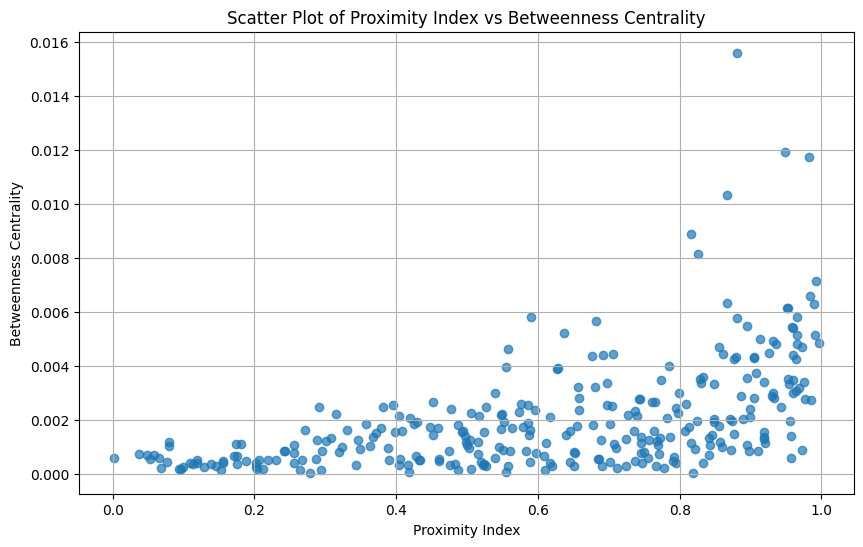

In [19]:
betweenness_centrality = nx.betweenness_centrality(GQ4)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
unique_stations = dfQ4[['target', 'TargetProximityIndex']].drop_duplicates()
priority_index_dict = dict(zip(unique_stations['target'], unique_stations['TargetProximityIndex']))
source_unique_stations = dfQ4[['source', 'SourceProximityIndex']].drop_duplicates()
source_priority_index_dict = dict(zip(source_unique_stations['source'], source_unique_stations['SourceProximityIndex']))
for key in source_priority_index_dict:
    if key not in priority_index_dict:
        priority_index_dict[key] = source_priority_index_dict[key]
sorted_priority_index_dict = dict(sorted(priority_index_dict.items(), key=lambda item: item[1], reverse=True)) 
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['station', 'betweenness'])
stations_df = pd.DataFrame(list(sorted_priority_index_dict.items()), columns=['station', 'proximity_index'])
merged_df = pd.merge(betweenness_df, stations_df, on='station')
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['proximity_index'], merged_df['betweenness'], alpha=0.7)
plt.title('Scatter Plot of Proximity Index vs Betweenness Centrality')
plt.ylabel('Betweenness Centrality')
plt.xlabel('Proximity Index')
plt.grid(True)
plt.show()

As we can see in the plot, there's some kind of relationship (Not necessarily a linear relationship though) between ProximityIndex and betweenness centrality, which is what we expected after seeing the correlation results.

In conclusion, we reject H0 and can conclude that our hypotesis is true.

As a bonus, let's use this data to make a random forest model that predicts the betweenness value of a node using its proximity index. This could help the company find the best places to build new stations before actually building them and regreting it later after spending millions of dollars.
We'll train the model and first using the Q4 network's data, and then test it on the whole data we have avilable (but first we'll test it against its own data).

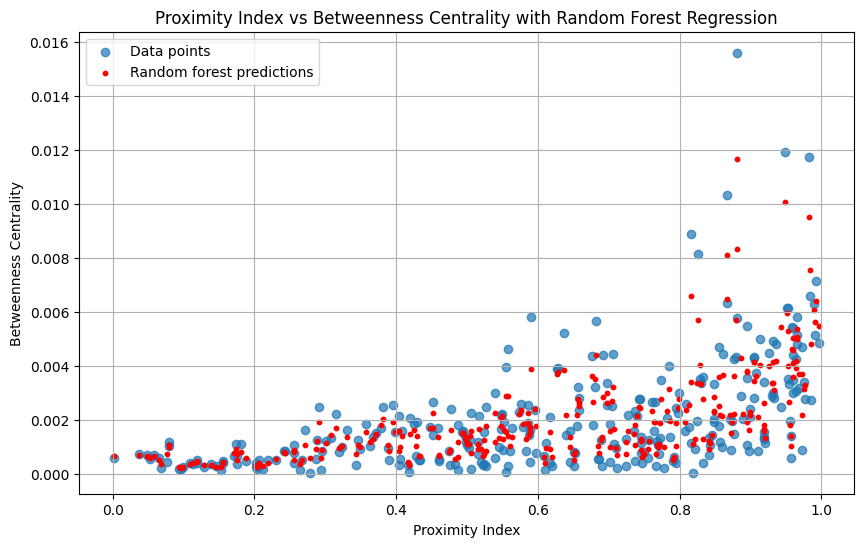

In [20]:
y = merged_df['betweenness'].values
X = merged_df[['proximity_index']].values
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_rf_pred = rf_model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['proximity_index'], merged_df['betweenness'], alpha=0.7, label='Data points')
plt.scatter(merged_df['proximity_index'], y_rf_pred, color='red', s=10, label='Random forest predictions')
plt.title('Proximity Index vs Betweenness Centrality with Random Forest Regression')
plt.ylabel('Betweenness Centrality')
plt.xlabel('Proximity Index')
plt.legend()
plt.grid(True)
plt.show()

As we can see, the model looks pretty close to its real values, which is a good sign!

Now let's test the model using dfAll which contains the data of all quarters combined.
We'll also print the model's MSE and R^2 metrics to evaluate the results.

Mean Absolute Error (MAE): 0.0006
Mean Squared Error (MSE): 0.0000
R² Score: 0.7641


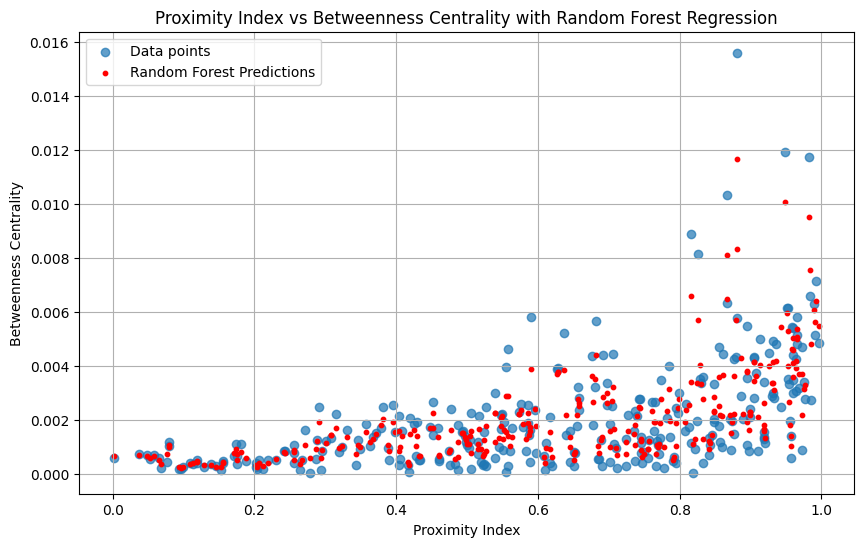

In [21]:
betweenness_centrality = nx.betweenness_centrality(GALL)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
unique_stations = dfAll[['target', 'TargetProximityIndex']].drop_duplicates()
priority_index_dict = dict(zip(unique_stations['target'], unique_stations['TargetProximityIndex']))
source_unique_stations = dfAll[['source', 'SourceProximityIndex']].drop_duplicates()
source_priority_index_dict = dict(zip(source_unique_stations['source'], source_unique_stations['SourceProximityIndex']))
for key in source_priority_index_dict:
    if key not in priority_index_dict:
        priority_index_dict[key] = source_priority_index_dict[key]
sorted_priority_index_dict = dict(sorted(priority_index_dict.items(), key=lambda item: item[1], reverse=True)) 
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['station', 'betweenness'])
stations_df = pd.DataFrame(list(sorted_priority_index_dict.items()), columns=['station', 'proximity_index'])
merged_df = pd.merge(betweenness_df, stations_df, on='station')
XPredict = merged_df[['proximity_index']].values
XPredictForPlotting = merged_df['proximity_index']
yPredictReal = merged_df['betweenness'].values

betweenness_centrality = nx.betweenness_centrality(GQ4)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
unique_stations = dfQ4[['target', 'TargetProximityIndex']].drop_duplicates()
priority_index_dict = dict(zip(unique_stations['target'], unique_stations['TargetProximityIndex']))
source_unique_stations = dfQ4[['source', 'SourceProximityIndex']].drop_duplicates()
source_priority_index_dict = dict(zip(source_unique_stations['source'], source_unique_stations['SourceProximityIndex']))
for key in source_priority_index_dict:
    if key not in priority_index_dict:
        priority_index_dict[key] = source_priority_index_dict[key]
sorted_priority_index_dict = dict(sorted(priority_index_dict.items(), key=lambda item: item[1], reverse=True)) 
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['station', 'betweenness'])
stations_df = pd.DataFrame(list(sorted_priority_index_dict.items()), columns=['station', 'proximity_index'])
merged_df = pd.merge(betweenness_df, stations_df, on='station')

y = merged_df['betweenness'].values
X = merged_df[['proximity_index']].values
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_rf_pred = rf_model.predict(XPredict)

# Calculate error metrics
mae = mean_absolute_error(yPredictReal, y_rf_pred)
mse = mean_squared_error(yPredictReal, y_rf_pred)
r2 = r2_score(yPredictReal, y_rf_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['proximity_index'], merged_df['betweenness'], alpha=0.7, label='Data points')
plt.scatter(XPredictForPlotting, y_rf_pred, color='red', s=10, label='Random Forest Predictions')
plt.title('Proximity Index vs Betweenness Centrality with Random Forest Regression')
plt.ylabel('Betweenness Centrality')
plt.xlabel('Proximity Index')
plt.legend()
plt.grid(True)
plt.show()

As we can see, the results are really good!
The predicted values look very close to the fitting data points, and the metrics suggest almost no errors, with 77% of R^2.

All in all, and after seeing all the analysis we've done, we conclude our first hypothesis to be true.

Now, let's test the other hypotheses. To do that, we'll first need to find a good community partition to our network.
We'll try the following methods to get a good community-partition and then write which one we'll choose and why:
Partitional Clustering
Hierarchical Clustering
K-Means
Hierarchical clustering
Density clustering
Girvan Newman
Spectral Clustering
Louvain
Note: We decided to not incude Clique Percolation Method (CPM) because it takes way too long to run (We tried several times with different parameters!)

We'll choose the best one as the partition with the largets modularity value.

Note: Some partitioning algorithms work on undirected graphs, and for them we'll use the underline graph of our networks (The same graph without directions) to use these algorithms.

Let's start partitaning with the Louvain method first.

In [22]:
def GetLouvainModularity(G):
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected, randomize=False)
    modularity_value = community_louvain.modularity(partition, G_undirected)
    return modularity_value

LouvainModularityQ1 = GetLouvainModularity(GQ1)
LouvainModularityQ2 = GetLouvainModularity(GQ2)
LouvainModularityQ3 = GetLouvainModularity(GQ3)
LouvainModularityQ4 = GetLouvainModularity(GQ4)
LouvainModularityALL = GetLouvainModularity(GALL)
print("Q1 network Louvain modularity:", LouvainModularityQ1)
print("Q2 network Louvain modularity:", LouvainModularityQ2)
print("Q3 network Louvain modularity:", LouvainModularityQ3)
print("Q4 network Louvain modularity:", LouvainModularityQ4)
print("All quarters combined network Louvain modularity:", LouvainModularityALL)
print('Mean Louvain for all networks:', sum([LouvainModularityQ1, LouvainModularityQ2, LouvainModularityQ3,
                                             LouvainModularityQ4, LouvainModularityALL]) / 5)
print('Standard deviation of their Louvain modularity:', statistics.stdev([LouvainModularityQ1, LouvainModularityQ2,
                                                                           LouvainModularityQ3, LouvainModularityQ4,
                                                                           LouvainModularityALL]))

Q1 network Louvain modularity: 0.298171362290134
Q2 network Louvain modularity: 0.3729186957401799
Q3 network Louvain modularity: 0.3777740540733156
Q4 network Louvain modularity: 0.3957437591555519
All quarters combined network Louvain modularity: 0.39219064683689797
Mean Louvain for all networks: 0.3673597036192159
Standard deviation of their Louvain modularity: 0.0398391077159769


As we can see, Louvain gave us good results in the following range: [0.3-0.39] with a mean value of 0.37

Now let's try partitaning using spectral clustering

In [23]:
def GetSpectralClusteringModularity(G):
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix = (adj_matrix + adj_matrix.T) / 2
    n_clusters = 3
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    labels = spectral.fit_predict(adj_matrix)
    community_map = {node: labels[i] for i, node in enumerate(G.nodes())}
    communities = [set() for _ in range(n_clusters)]
    for node, community in community_map.items():
        communities[community].add(node)
    modularity_value = modularity(G.to_undirected(), communities)
    return modularity_value

SpectralModularityQ1 = GetSpectralClusteringModularity(GQ1)
SpectralModularityQ2 = GetSpectralClusteringModularity(GQ2)
SpectralModularityQ3 = GetSpectralClusteringModularity(GQ3)
SpectralModularityQ4 = GetSpectralClusteringModularity(GQ4)
SpectralModularityAll = GetSpectralClusteringModularity(GALL)

print("Q1 network Spectral Clustering modularity:", SpectralModularityQ1)
print("Q2 network Spectral Clustering modularity:", SpectralModularityQ2)
print("Q3 network Spectral Clustering modularity:", SpectralModularityQ3)
print("Q4 network Spectral Clustering modularity:", SpectralModularityQ4)
print("All quarters combined network Spectral Clustering modularity:", SpectralModularityAll)
print('Mean Spectral Clustering modularity for all networks:', sum([SpectralModularityQ1, SpectralModularityQ2, SpectralModularityQ3,
                                             SpectralModularityQ4, SpectralModularityAll]) / 5)
print('Standard deviation of their Spectral Clustering modularity:', statistics.stdev([SpectralModularityQ1, SpectralModularityQ2, SpectralModularityQ3,
                                             SpectralModularityQ4, SpectralModularityAll]))

Q1 network Spectral Clustering modularity: 0.24516491809802676
Q2 network Spectral Clustering modularity: 0.2275644614746959
Q3 network Spectral Clustering modularity: 0.22420382253307897
Q4 network Spectral Clustering modularity: 0.27965071745692877
All quarters combined network Spectral Clustering modularity: 0.22526254570654683
Mean Spectral Clustering modularity for all networks: 0.24036929305385546
Standard deviation of their Spectral Clustering modularity: 0.023555934958322065


As we can see, spectral clustering performes worse than Louvain, thus we'll choose Louvain over this method.

Now let's try the Girvan-Newman algorithm

In [24]:
def GetGirvanNewmanModularity(G):
    comp = girvan_newman(G)
    limited = itertools.takewhile(lambda c: len(c) <= 10, comp)
    communities = next(limited)
    community_map = {}
    for i, community in enumerate(communities):
        for node in community:
            community_map[node] = i
    modularity_value = modularity(G, communities)
    return modularity_value

GirvanNewmanModularityQ1 = GetGirvanNewmanModularity(GQ1)
GirvanNewmanModularityQ2 = GetGirvanNewmanModularity(GQ2)
GirvanNewmanModularityQ3 = GetGirvanNewmanModularity(GQ3)
GirvanNewmanModularityQ4 = GetGirvanNewmanModularity(GQ4)
GirvanNewmanModularityAll = GetGirvanNewmanModularity(GALL)

print("Q1 network Girvan-Newman modularity:", GirvanNewmanModularityQ1)
print("Q2 network Girvan-Newman modularity:", GirvanNewmanModularityQ2)
print("Q3 network Girvan-Newman modularity:", GirvanNewmanModularityQ3)
print("Q4 network Girvan-Newman modularity:", GirvanNewmanModularityQ4)
print("All quarters combined network Girvan-Newman modularity:", GirvanNewmanModularityAll)
print('Mean Girvan-Newman for all networks:', sum([GirvanNewmanModularityQ1, GirvanNewmanModularityQ2, GirvanNewmanModularityQ3,
                                             GirvanNewmanModularityQ4, GirvanNewmanModularityAll]) / 5)
print('Standard deviation of their Girvan-Newman modularity:', statistics.stdev([GirvanNewmanModularityQ1, GirvanNewmanModularityQ2,
                                                                                 GirvanNewmanModularityQ3, GirvanNewmanModularityQ4,
                                                                                 GirvanNewmanModularityAll]))

Q1 network Girvan-Newman modularity: 1.1102230246251565e-16
Q2 network Girvan-Newman modularity: 0.016271394269287802
Q3 network Girvan-Newman modularity: 0.0010118524772846223
Q4 network Girvan-Newman modularity: 5.082213298850189e-06
All quarters combined network Girvan-Newman modularity: 1.8363296663894866e-05
Mean Girvan-Newman for all networks: 0.0034613384513070564
Standard deviation of their Girvan-Newman modularity: 0.007174227494467117


As seen above, Girvan-Newman's modularity is low for all our networks and thus we won't use it.

Let's try using density clurstering

In [25]:
def GetDensityClusteringModularity(G):
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix_combined = adj_matrix + adj_matrix.T
    eps = 0.5  # distance threshold
    min_samples = 3  # minimum number of points in a neighborhood to form a cluster
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(adj_matrix_combined)
    node_clusters = {node: label for node, label in zip(G.nodes(), labels)}
    clusters = {}
    for node, cluster in node_clusters.items():
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(node)
    # Convert to list of sets
    communities = [set(cluster) for cluster in clusters.values() if cluster != -1]  # Exclude noise (-1)
    # Calculate modularity
    modularity_value = modularity(G, communities)
    return modularity_value

DensityClusteringModularityQ1 = GetDensityClusteringModularity(GQ1)
DensityClusteringModularityQ2 = GetDensityClusteringModularity(GQ2)
DensityClusteringModularityQ3 = GetDensityClusteringModularity(GQ3)
DensityClusteringModularityQ4 = GetDensityClusteringModularity(GQ4)
DensityClusteringModularityAll = GetDensityClusteringModularity(GALL)

print("Q1 network density clustering modularity:", DensityClusteringModularityQ1)
print("Q2 network density clustering modularity:", DensityClusteringModularityQ2)
print("Q3 network density clustering modularity:", DensityClusteringModularityQ3)
print("Q4 network density clustering modularity:", DensityClusteringModularityQ4)
print("All quarters combined network density clustering modularity:", DensityClusteringModularityAll)
print('Mean density clustering for all networks:', sum([DensityClusteringModularityQ1, DensityClusteringModularityQ2, DensityClusteringModularityQ3,
                                             DensityClusteringModularityQ4, DensityClusteringModularityAll]) / 5)
print('Standard deviation of their density clustering modularity:', statistics.stdev([DensityClusteringModularityQ1, DensityClusteringModularityQ2,
                                                                                 DensityClusteringModularityQ3, DensityClusteringModularityQ4,
                                                                                 DensityClusteringModularityAll]))

Q1 network density clustering modularity: 0.0
Q2 network density clustering modularity: 0.0
Q3 network density clustering modularity: 0.0
Q4 network density clustering modularity: 0.0
All quarters combined network density clustering modularity: 0.0
Mean density clustering for all networks: 0.0
Standard deviation of their density clustering modularity: 0.0


Density clustering didn't give us good results. We can see that the modularity value is close to zero.

In [26]:
def GetHierarchicalClusteringModularity(G):
    adj_matrix = nx.to_numpy_array(G)
    incoming_distance_matrix = squareform(pdist(adj_matrix.T, metric='euclidean'))
    outgoing_distance_matrix = squareform(pdist(adj_matrix, metric='euclidean'))
    combined_distance_matrix = (incoming_distance_matrix + outgoing_distance_matrix) / 2
    Z = linkage(squareform(combined_distance_matrix), method='complete')
    threshold = 1.5
    labels = fcluster(Z, t=threshold, criterion='distance')
    node_clusters = {node: label for node, label in zip(G.nodes(), labels)}
    clusters = {}
    for node, cluster in node_clusters.items():
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(node)
    communities = [set(cluster) for cluster in clusters.values() if cluster != -1]  # Exclude noise (-1)
    modularity_value = modularity(G.to_undirected(), communities)
    return modularity_value

HierarchicalClusteringModularityQ1 = GetHierarchicalClusteringModularity(GQ1)
HierarchicalClusteringModularityQ2 = GetHierarchicalClusteringModularity(GQ2)
HierarchicalClusteringModularityQ3 = GetHierarchicalClusteringModularity(GQ3)
HierarchicalClusteringModularityQ4 = GetHierarchicalClusteringModularity(GQ4)
HierarchicalClusteringModularityAll = GetHierarchicalClusteringModularity(GALL)

print("Q1 network hierarchical clustering modularity:", HierarchicalClusteringModularityQ1)
print("Q2 network hierarchical clustering modularity:", HierarchicalClusteringModularityQ2)
print("Q3 network hierarchical clustering modularity:", HierarchicalClusteringModularityQ3)
print("Q4 network hierarchical clustering modularity:", HierarchicalClusteringModularityQ4)
print("All quarters combined network hierarchical clustering modularity:", HierarchicalClusteringModularityAll)
print('Mean hierarchical clustering for all networks:', sum([HierarchicalClusteringModularityQ1, HierarchicalClusteringModularityQ2,
                                                             HierarchicalClusteringModularityQ3, HierarchicalClusteringModularityQ4,
                                                             HierarchicalClusteringModularityAll]) / 5)
print('Standard deviation of their hierarchical clustering modularity:', statistics.stdev([HierarchicalClusteringModularityQ1, HierarchicalClusteringModularityQ2,
                                                             HierarchicalClusteringModularityQ3, HierarchicalClusteringModularityQ4,
                                                             HierarchicalClusteringModularityAll]))

Q1 network hierarchical clustering modularity: 0.13223500398210739
Q2 network hierarchical clustering modularity: 0.027712292106477833
Q3 network hierarchical clustering modularity: 0.03453911715110724
Q4 network hierarchical clustering modularity: 0.08182390733340789
All quarters combined network hierarchical clustering modularity: 0.08122948557157433
Mean hierarchical clustering for all networks: 0.07150796122893494
Standard deviation of their hierarchical clustering modularity: 0.04234813032311767


Hierarchical clustering also doesn't provide us with a good partition.
Let's try using K-Means.

In [27]:
def GetKMeansModularity(G, num_clusters):
    adj_matrix = nx.to_numpy_array(G)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    labels = kmeans.fit_predict(adj_matrix)
    node_clusters = {node: label for node, label in zip(G.nodes(), labels)}
    clusters = {}
    for node, cluster in node_clusters.items():
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(node)
    communities = [set(cluster) for cluster in clusters.values() if cluster != -1]  # Exclude noise (-1)
    modularity_value = modularity(G, communities)
    return modularity_value

k = 5
KMeansModularityQ1 = GetKMeansModularity(GQ1, k)
KMeansModularityQ2 = GetKMeansModularity(GQ2, k)
KMeansModularityQ3 = GetKMeansModularity(GQ3, k)
KMeansModularityQ4 = GetKMeansModularity(GQ4, k)
KMeansModularityAll = GetKMeansModularity(GALL, k)

print("Q1 network KMeans modularity:", KMeansModularityQ1, 'K =', k)
print("Q2 network KMeans modularity:", KMeansModularityQ2)
print("Q3 network KMeans modularity:", KMeansModularityQ3)
print("Q4 network KMeans modularity:", KMeansModularityQ4)
print("All quarters combined network KMeans modularity:", KMeansModularityAll)
print('Mean KMeans for all networks:', sum([KMeansModularityQ1, KMeansModularityQ2, KMeansModularityQ3, KMeansModularityQ4,
                                                             KMeansModularityAll]) / 5)
print('Standard deviation of their KMeans modularity:', statistics.stdev([KMeansModularityQ1, KMeansModularityQ2, KMeansModularityQ3, KMeansModularityQ4,
                                                             KMeansModularityAll]))

Q1 network KMeans modularity: 0.14768681211759066 K = 5
Q2 network KMeans modularity: 0.15695079210313148
Q3 network KMeans modularity: 0.18202888271342513
Q4 network KMeans modularity: 0.10593242021300048
All quarters combined network KMeans modularity: 0.2433310237830441
Mean KMeans for all networks: 0.16718598618603836
Standard deviation of their KMeans modularity: 0.05063436249142431


These results are not bad, but still Louvain's results were better.
Note: We tried several k values and found 5 to give us the best results.

Now let's try Partitional Clustering

In [28]:
def GetPartitionalClusteringModularity(G, num_clusters):
    adj_matrix = nx.to_numpy_array(G)
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=0)
    labels = kmedoids.fit_predict(adj_matrix)
    node_clusters = {node: label for node, label in zip(G.nodes(), labels)}
    clusters = {}
    for node, cluster in node_clusters.items():
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(node)
    communities = [set(cluster) for cluster in clusters.values() if cluster != -1]  # Exclude noise (-1)
    modularity_value = modularity(G, communities)
    return modularity_value

k = 3
PartitionalClusteringModularityQ1 = GetPartitionalClusteringModularity(GQ1, k)
PartitionalClusteringModularityQ2 = GetPartitionalClusteringModularity(GQ2, k)
PartitionalClusteringModularityQ3 = GetPartitionalClusteringModularity(GQ3, k)
PartitionalClusteringModularityQ4 = GetPartitionalClusteringModularity(GQ4, k)
PartitionalClusteringModularityAll = GetPartitionalClusteringModularity(GALL, k)

print('K =', k)
print("Q1 network KMeans modularity:", PartitionalClusteringModularityQ1)
print("Q2 network KMeans modularity:", PartitionalClusteringModularityQ2)
print("Q3 network KMeans modularity:", PartitionalClusteringModularityQ3)
print("Q4 network KMeans modularity:", PartitionalClusteringModularityQ4)
print("All quarters combined network KMeans modularity:", PartitionalClusteringModularityAll)
print('Mean KMeans for all networks:', sum([PartitionalClusteringModularityQ1, PartitionalClusteringModularityQ2, PartitionalClusteringModularityQ3,
                                            PartitionalClusteringModularityQ4, PartitionalClusteringModularityAll]) / 5)
print('Standard deviation of their KMeans modularity:', statistics.stdev([PartitionalClusteringModularityQ1, PartitionalClusteringModularityQ2, PartitionalClusteringModularityQ3,
                                            PartitionalClusteringModularityQ4, PartitionalClusteringModularityAll]))

K = 3
Q1 network KMeans modularity: 0.14489054707831017
Q2 network KMeans modularity: 0.06663317774811137
Q3 network KMeans modularity: 0.2755891820616553
Q4 network KMeans modularity: 0.28501281672560674
All quarters combined network KMeans modularity: 0.2874931529836318
Mean KMeans for all networks: 0.21192377531946308
Standard deviation of their KMeans modularity: 0.10088215186659444


Partitional clustering gives us worse values than Louvain KMeans and thus we won't use it.

In conclusion, Louvain gave us the best results with largest modularity values and thus we'll use Louvain's method to get communities and partition the graph.

Let's plot its partition on our complete network. We'll only print 2% of the edges (which are being chosen randomally) because there are too many edges in the whole graph and we wouldn't be able to see anything otherwise.

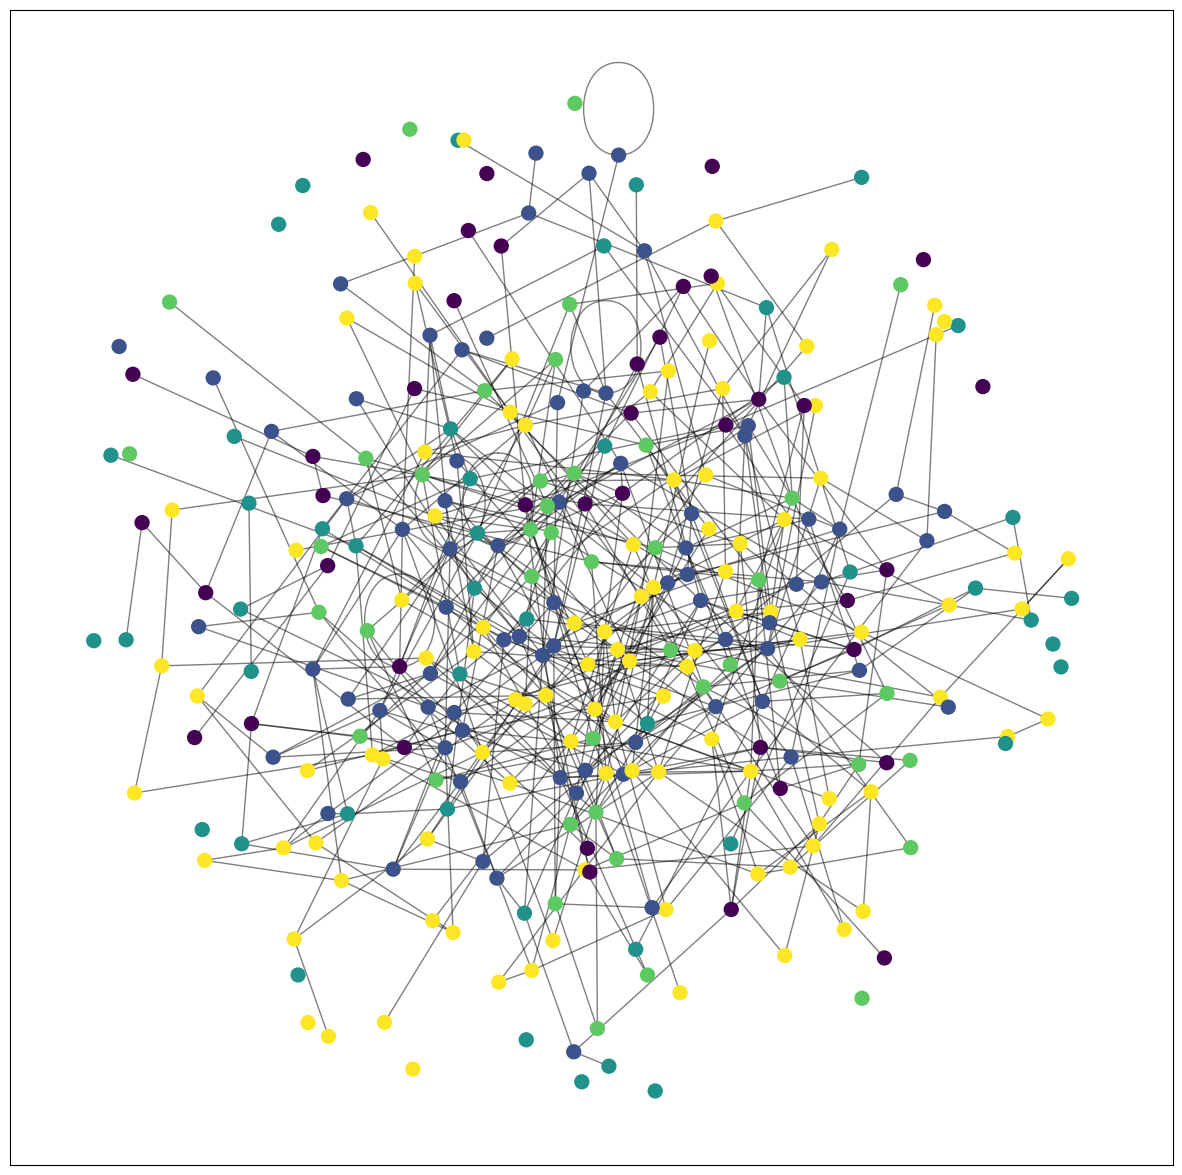

In [29]:
# Convert the graph to undirected
GALL_undirected = GALL.to_undirected()

# Get the partition (community assignment) using the Louvain method
partition = community_louvain.best_partition(GALL_undirected, randomize=False)

# Sample a subset of edges to display
num_edges = len(GALL_undirected.edges())
edges_list = list(GALL_undirected.edges())
sampled_edges = random.sample(edges_list, k=int(num_edges * 0.02))  # Display 5% of edges

# Create a new graph with the sampled edges
GALL_sampled = nx.Graph()
GALL_sampled.add_edges_from(sampled_edges)
GALL_sampled.add_nodes_from(GALL_undirected.nodes())  # Add all nodes to keep the partition consistent

# Draw the graph
pos = nx.spring_layout(GALL_sampled, k=0.3, iterations=50)  # Adjust k for better spacing

# Assign colors to communities
unique_communities = list(set(partition.values()))
color_map = {community: idx for idx, community in enumerate(unique_communities)}
cmap = plt.get_cmap('viridis', len(unique_communities))

# Create a list of colors for nodes
node_colors = [color_map[partition[node]] for node in GALL_sampled.nodes()]

# Plot the graph
plt.figure(figsize=(15, 15))  # Increase the figure size
nx.draw_networkx_edges(GALL_sampled, pos, alpha=0.5)
nx.draw_networkx_nodes(GALL_sampled, pos, node_size=100, node_color=node_colors, cmap=cmap)
#nx.draw_networkx_labels(GALL_sampled, pos, font_size=10)

# Show the plot
plt.show()

As we can see, we have 5 communities in total.

Now, we'd like to check whether there's a difference between places with high income, and low income, and if so, what is it.

We've read an article about a similar network in Spain which states that the likelihood of two neighborhoods being connected increases as their wealth levels rise. They also found that the probability that there are routes connecting two stations in wealthy neighborhoods is more than twice as high compared to routes connecting stations in poor neighborhoods. Additionally, the probability of a route connecting a wealthy neighborhood to a poor neighborhood is more than 50% higher than that of a route connecting two poor neighborhoods. In other words, the more stations in wealthy neighborhoods a route has, the higher the probability of the route existing.

Source:
Suárez-Vega, Rafael, Yolanda Santana-Jiménez, Juan M. Hernández, and José Juan Santana-Figueroa. 2023. "Assessment of the Bike-Sharing Socioeconomic Equity in the Use of Routes" ISPRS International Journal of Geo-Information 12, no. 8: 320. https://doi.org/10.3390/ijgi12080320

First, let's build a dictionary for stations and their neighborhood median income.
We'll print the minimum, maximum, average, median, and stardard deviation of the values.
Here we'll implement functions to help us check the hypothesis and then use them on all networks.
We'll first start with the network of quarter 1.

In [30]:
def calculate_income_statistics(df):
  # Create dictionaries mapping stations to their median incomes
  source_income_dict = df.set_index('source')['SourceMedianIncome'].to_dict()
  target_income_dict = df.set_index('target')['TargetMedianIncome'].to_dict()

  # Combine the dictionaries
  station_income_dict = {**source_income_dict, **target_income_dict}

  # Ensure all station incomes are included (if a station is both in source and target, the value will be the same)
  for station in df['target'].unique():
      if station not in station_income_dict:
          station_income_dict[station] = df[df['target'] == station]['TargetMedianIncome'].values[0]
  # Extract incomes as a list
  incomes = list(station_income_dict.values())
  return incomes

incomes = calculate_income_statistics(dfQ1)
# Calculate statistics
print('Min income:', np.min(incomes))
print('Man income:', np.max(incomes))
print('Average income:', np.mean(incomes))
print('Median income:', np.median(incomes))
print('Standard deviation of income:', np.std(incomes))

Min income: 18100
Man income: 133322
Average income: 97623.08947368422
Median income: 109634.0
Standard deviation of income: 29060.60201820354


Now let's use this dictionary to calculate the percentage of high income neighborhoods (for each community)
The threshold to be considered high income is 121080 and for being poor is 50450, according to data we found on the City of Chicago's government website.
We'll plot a bar chart showing the percentage of rich stations in each community.

We'll define a community's income by its highest percentage of income stations. For example, if 40% of the stations in some community are considered poor, 30% are middle-class, and 30% are rich the community will be considered poor.

We are using Q1 network first, and then after fully implementing the functions we are going to use our other networks as well.

Source:
City of Chicago Municipal Government. Used 3 persons household income because this is the closest integer to the average household size in the city of Chicago.
https://www.chicago.gov/content/dam/city/depts/doh/general/Income_and_Rent_Limit_Tables/2024%20Income%20Limit%20Chart.pdf

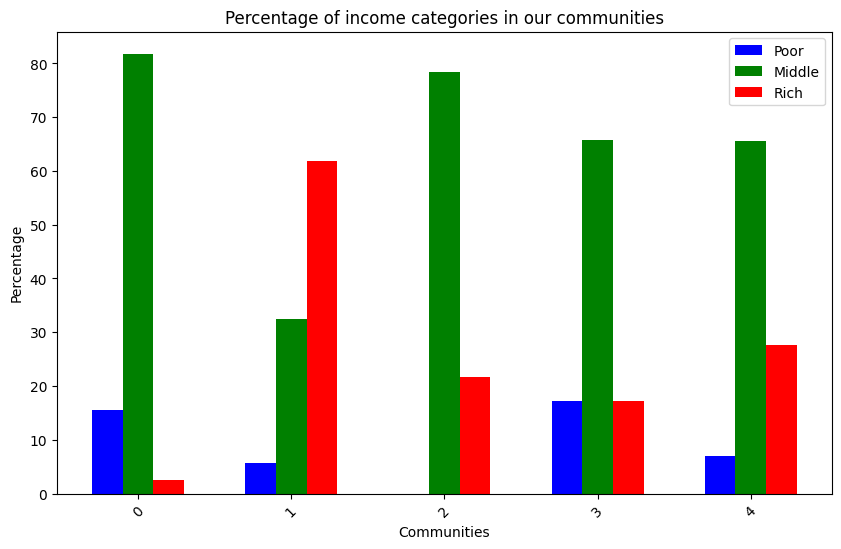

In [31]:
poor_threshold=50450
rich_threshold=121080

def get_df_with_income_category_label_columns(df, poor_threshold=50450, rich_threshold=121080):

    df_copy = df.copy()
    
    def classify_income(income):
        if income < poor_threshold:
            return 'poor'
        elif income <= rich_threshold:
            return 'middle'
        else:
            return 'rich'

    df_copy['SourceIncomeCategory'] = df_copy['SourceMedianIncome'].apply(classify_income)
    df_copy['TargetIncomeCategory'] = df_copy['TargetMedianIncome'].apply(classify_income)
    
    return df_copy

def classify_and_plot_income_categories(df, G, poor_threshold=50450, rich_threshold=121080):
    # Ensure the df has income categories labeled
    df = get_df_with_income_category_label_columns(df, poor_threshold, rich_threshold)
    
    # Convert the graph to undirected
    G_undirected = G.to_undirected()

    # Get the partition (community assignment) using the Louvain method
    partition = community_louvain.best_partition(G_undirected, randomize=False)

    # Create dictionaries to count the number of stations in each category for each community
    community_poor_count = {}
    community_middle_count = {}
    community_rich_count = {}
    community_total_count = {}

    for station, community in partition.items():
        if community not in community_poor_count:
            community_poor_count[community] = 0
            community_middle_count[community] = 0
            community_rich_count[community] = 0
            community_total_count[community] = 0

        # Check source and target categories and count them
        if station in df['source'].values:
            source_category = df[df['source'] == station]['SourceIncomeCategory'].values[0]
            if source_category == 'poor':
                community_poor_count[community] += 1
            elif source_category == 'middle':
                community_middle_count[community] += 1
            elif source_category == 'rich':
                community_rich_count[community] += 1

            community_total_count[community] += 1

        if station in df['target'].values:
            target_category = df[df['target'] == station]['TargetIncomeCategory'].values[0]
            if target_category == 'poor':
                community_poor_count[community] += 1
            elif target_category == 'middle':
                community_middle_count[community] += 1
            elif target_category == 'rich':
                community_rich_count[community] += 1

            community_total_count[community] += 1

    # Calculate the percentage of each category in each community
    community_poor_percentage = {community: (community_poor_count[community] / community_total_count[community]) * 100
                                 for community in community_poor_count}
    community_middle_percentage = {community: (community_middle_count[community] / community_total_count[community]) * 100
                                   for community in community_middle_count}
    community_rich_percentage = {community: (community_rich_count[community] / community_total_count[community]) * 100
                                 for community in community_rich_count}

    # Extracting keys and values
    labels = list(community_poor_percentage.keys())
    poor_values = list(community_poor_percentage.values())
    middle_values = list(community_middle_percentage.values())
    rich_values = list(community_rich_percentage.values())

    # Creating the bar chart
    x = range(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    plt.bar(x, poor_values, width, label='Poor', color='blue')
    plt.bar([i + width for i in x], middle_values, width, label='Middle', color='green')
    plt.bar([i + 2 * width for i in x], rich_values, width, label='Rich', color='red')

    # Adding titles and labels
    plt.title('Percentage of income categories in our communities')
    plt.xlabel('Communities')
    plt.ylabel('Percentage')
    plt.xticks([i + width for i in x], labels, rotation=45)
    plt.legend()

    # Display the plot
    plt.show()
    
    return df

dfQ1_with_labels = classify_and_plot_income_categories(dfQ1, GQ1)

As we can see, almost all communities are middle-class.

Now we'll define some functions to help us calculate the trips contingency table, and perform a chi-squared test.
The contingency table counts the number of trips coming out from (source) and in to (target) from each income type (poor, middle, rich)
Then we are using the contingency table to calculate all the chi-squared variables (such as p-value, degrees of freedom, etc.) and print its results.

Chi-Square Statistic: 10645.117732776085
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[12146.18334271 23255.81665729]
 [20792.81665729 39811.18334271]]


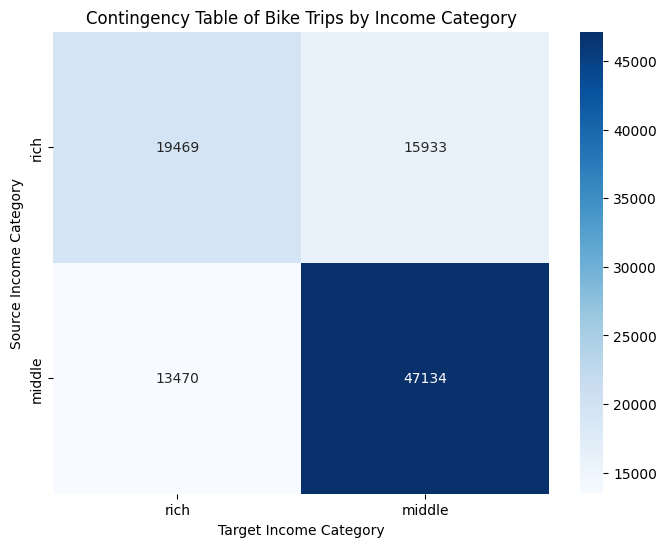

In [32]:
def aggregate_by_income_category(df, partition, community_classification):
    # Create an empty DataFrame for the contingency table
    contingency_table = pd.DataFrame(0, index=['rich', 'middle', 'poor'], columns=['rich', 'middle', 'poor'])
    
    for _, row in df.iterrows():
        source = row['source']
        target = row['target']
        
        if source not in partition or target not in partition:
            continue
        
        source_community = partition[source]
        target_community = partition[target]

        # If we want to use only inter-community trips, we can use the following code
        #if source_community == target_community:
        #    continue
        
        source_income_category = community_classification.get(source_community, 'unknown')
        target_income_category = community_classification.get(target_community, 'unknown')
        
        if source_income_category in contingency_table.index and target_income_category in contingency_table.columns:
            contingency_table.loc[source_income_category, target_income_category] += 1
    
    # Ensure all categories are included
    contingency_table = contingency_table.reindex(index=['rich', 'middle', 'poor'], columns=['rich', 'middle', 'poor'], fill_value=0)
    
    # Remove rows and columns where all values are zero
    contingency_table = contingency_table.loc[(contingency_table.sum(axis=1) > 0), (contingency_table.sum(axis=0) > 0)]
    
    return contingency_table

def perform_chi_square_test(contingency_table):
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2, p, dof, expected

def analyze_income_influence_on_trips(df, G):
    # Convert the graph to undirected
    G_undirected = G.to_undirected()

    # Get the partition (community assignment) using the Louvain method
    partition = community_louvain.best_partition(G_undirected, randomize=False)
    
    # Create dictionaries to count the number of stations in each category for each community
    community_poor_count = {}
    community_middle_count = {}
    community_rich_count = {}
    community_total_count = {}

    for station, community in partition.items():
        if community not in community_poor_count:
            community_poor_count[community] = 0
            community_middle_count[community] = 0
            community_rich_count[community] = 0
            community_total_count[community] = 0

        if station in df['source'].values:
            source_category = df[df['source'] == station]['SourceIncomeCategory'].values[0]
            if source_category == 'poor':
                community_poor_count[community] += 1
            elif source_category == 'middle':
                community_middle_count[community] += 1
            elif source_category == 'rich':
                community_rich_count[community] += 1

            community_total_count[community] += 1

        if station in df['target'].values:
            target_category = df[df['target'] == station]['TargetIncomeCategory'].values[0]
            if target_category == 'poor':
                community_poor_count[community] += 1
            elif target_category == 'middle':
                community_middle_count[community] += 1
            elif target_category == 'rich':
                community_rich_count[community] += 1

            community_total_count[community] += 1

    # Calculate the percentage of each category in each community
    community_poor_percentage = {community: (community_poor_count[community] / community_total_count[community]) * 100
                                 for community in community_poor_count}
    community_middle_percentage = {community: (community_middle_count[community] / community_total_count[community]) * 100
                                   for community in community_middle_count}
    community_rich_percentage = {community: (community_rich_count[community] / community_total_count[community]) * 100
                                 for community in community_rich_count}

    # Classify each community by its dominant income category
    community_classification = {}
    for community in community_poor_percentage:
        percentages = {
            'poor': community_poor_percentage.get(community, 0),
            'middle': community_middle_percentage.get(community, 0),
            'rich': community_rich_percentage.get(community, 0)
        }
        dominant_category = max(percentages, key=percentages.get)
        community_classification[community] = dominant_category

    # Aggregate data and perform the Chi-Square test
    contingency_table_by_income = aggregate_by_income_category(df, partition, community_classification)
    
    if not contingency_table_by_income.empty:
        chi2, p, dof, expected = perform_chi_square_test(contingency_table_by_income)

        print("Chi-Square Statistic:", chi2)
        print("p-value:", p)
        print("Degrees of Freedom:", dof)
        print("Expected Frequencies:")
        print(expected)
    else:
        print("Contingency table is empty after filtering zeroes.")

    # Plotting the contingency table
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table_by_income, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Contingency Table of Bike Trips by Income Category')
    plt.xlabel('Target Income Category')
    plt.ylabel('Source Income Category')
    plt.show()

# Running the analysis on dfQ1 and GQ1
analyze_income_influence_on_trips(dfQ1_with_labels, GQ1)

As we can see, the p-value is very low and we can see that there are much more same income level trips than other kind of trips.
Thus, for Q1's network, we can reject the null hypothesis.
Notice that "poor" income type isn't in the table since there are no communities which are considered "poor" in this network.

Now let's see Q2's network.

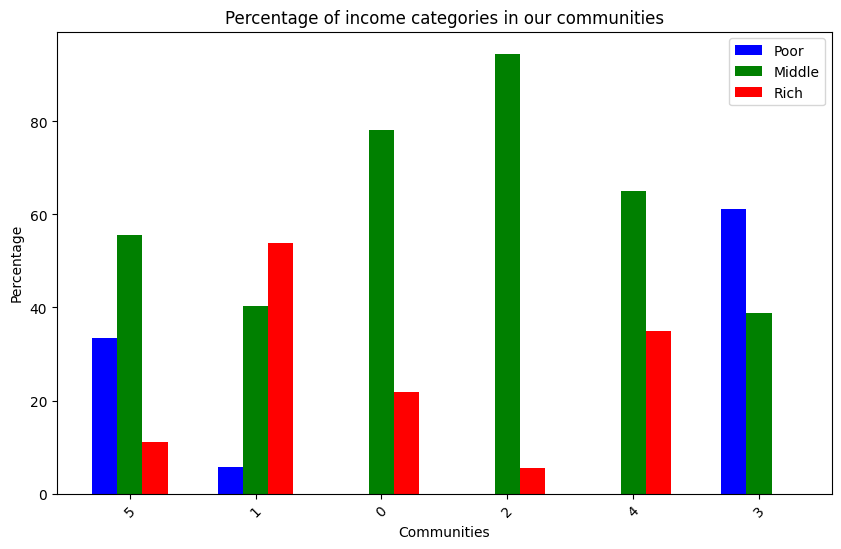

In [33]:
dfQ2_with_labels = classify_and_plot_income_categories(dfQ2, GQ2)

Now we have more types of communities. For example 5 is middle-class, 3 is poor, and 1 is rich.
Now let's calculate the contingency table and print its results.

Chi-Square Statistic: 63875.25885733306
p-value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[8.81373925e+03 1.56029685e+04 2.42292198e+02]
 [1.53867822e+04 2.72392308e+04 4.22987016e+02]
 [2.44478594e+02 4.32800620e+02 6.72078606e+00]]


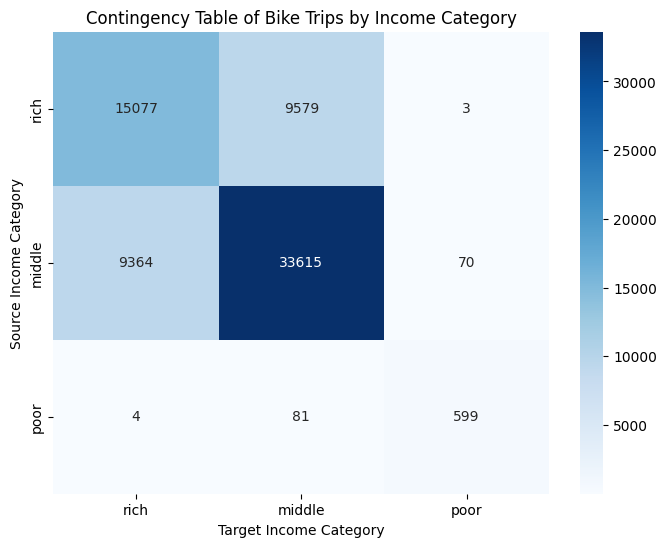

In [34]:
analyze_income_influence_on_trips(dfQ2_with_labels, GQ2)

As we can see above, the p-value is still very low (it's so low that it gets print as zero!)
We can also see in the table that same income level trips are way more common.
We are rejecting the null hypothesis for Q2 as well.

Now let's test it all on Q3's network.

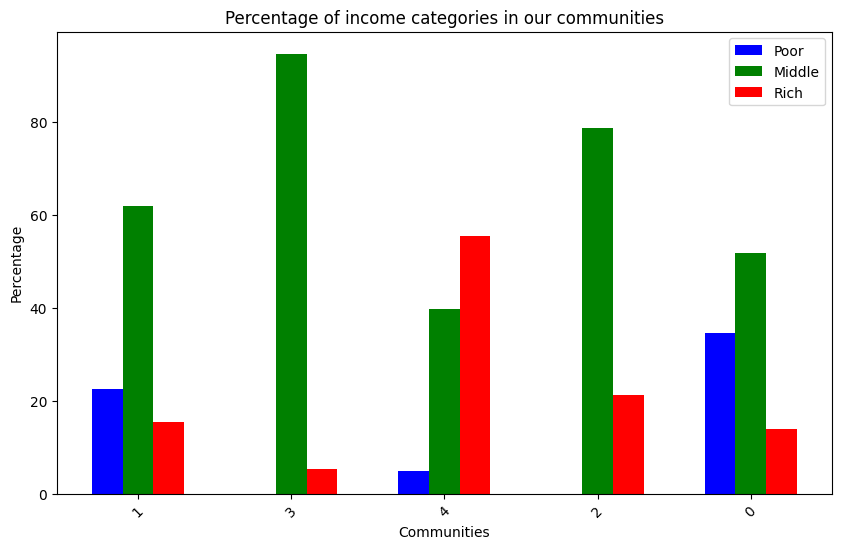

In [35]:
dfQ3_with_labels = classify_and_plot_income_categories(dfQ3, GQ3)

Chi-Square Statistic: 25223.38972915369
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[21402.09933001 24780.90066999]
 [23418.90066999 27116.09933001]]


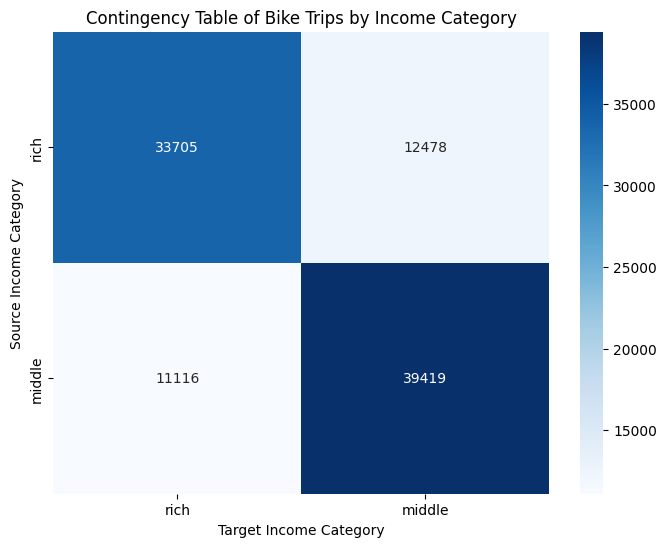

In [36]:
analyze_income_influence_on_trips(dfQ3_with_labels, GQ3)

Again, we can reject the null hypothesis since the p-value is so low.
So far we are doing good.

Now let's check Q4's network.

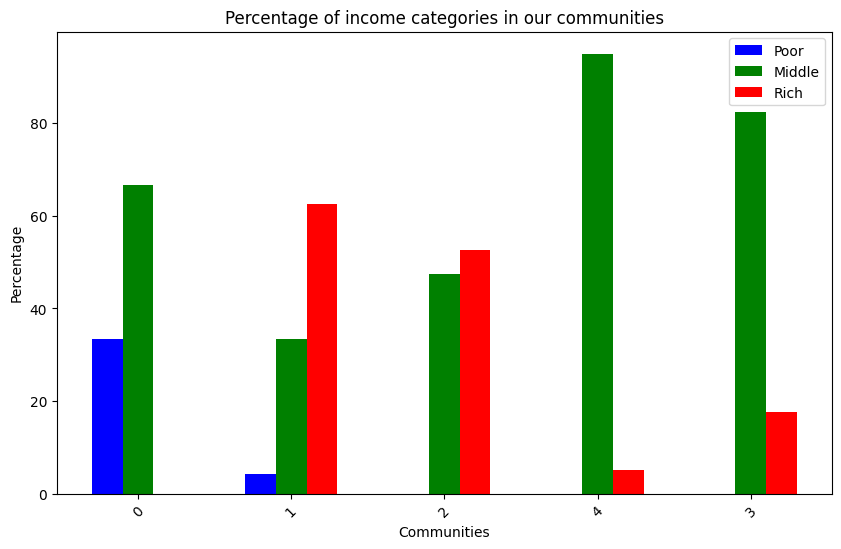

In [37]:
dfQ4_with_labels = classify_and_plot_income_categories(dfQ4, GQ4)

Chi-Square Statistic: 107547.44323166924
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[125366.47158076  97605.52841924]
 [ 94762.52841924  73778.47158076]]


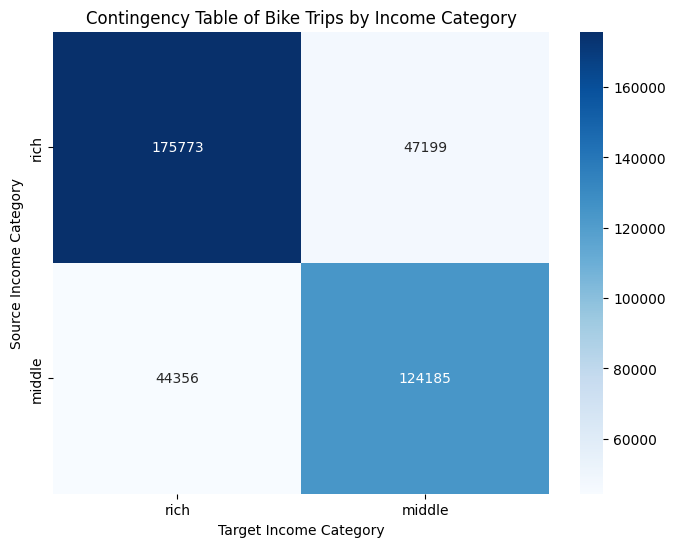

In [38]:
analyze_income_influence_on_trips(dfQ4_with_labels, GQ4)

The p-value is very close to zero again which means we can reject the null hypothesis.

For the last network, we'll check the network that contains all the trips combined.

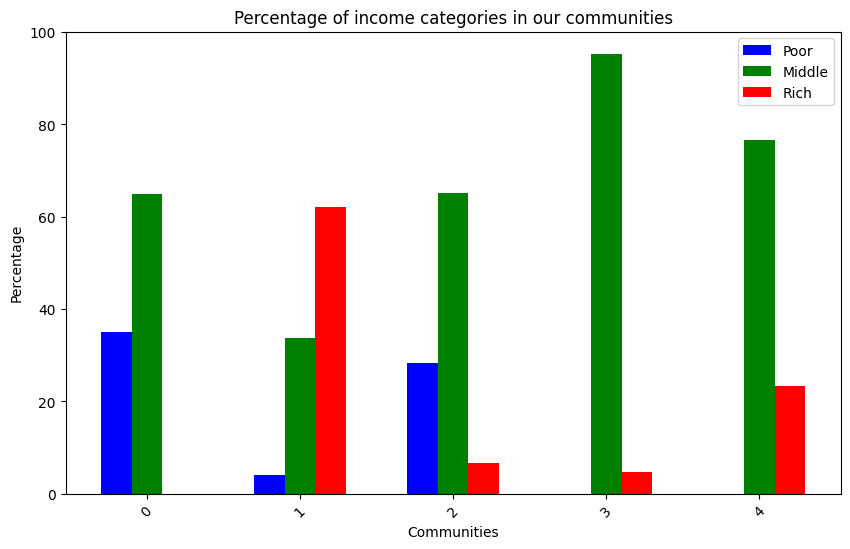

In [39]:
dfALL_with_labels = classify_and_plot_income_categories(dfAll, GALL)

Chi-Square Statistic: 164495.5913388819
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[122477.29131252 165934.70868748]
 [154668.70868748 209548.29131252]]


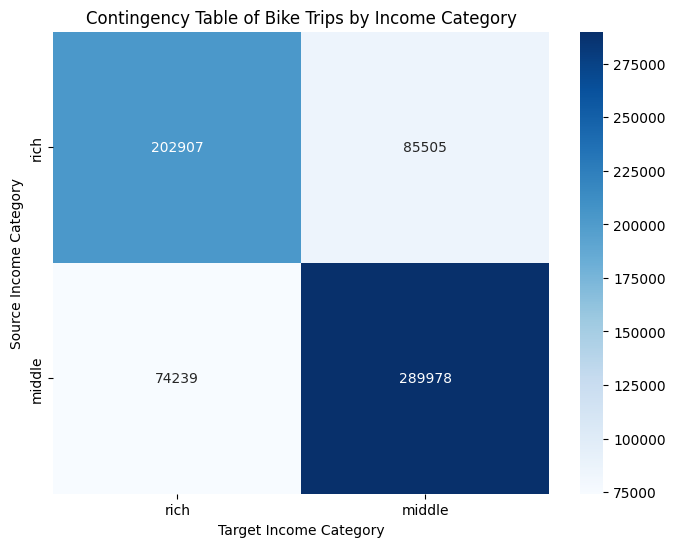

In [40]:
analyze_income_influence_on_trips(dfALL_with_labels, GALL)

Same great results.

Before we conclude our hypothesis to be true, we want to first check the same thing but only using inter-community trips just to make sure we don't have a big bias since intra-community trips tend to add way more same income type trips to our data.

We'll define the functions again, just for inter-community trips and test the hypothesis again for all networks, starting with Q1.

Chi-Square Statistic: 9509.147176296055
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[ 4523.59645055 11409.40354945]
 [ 8946.40354945 22564.59645055]]


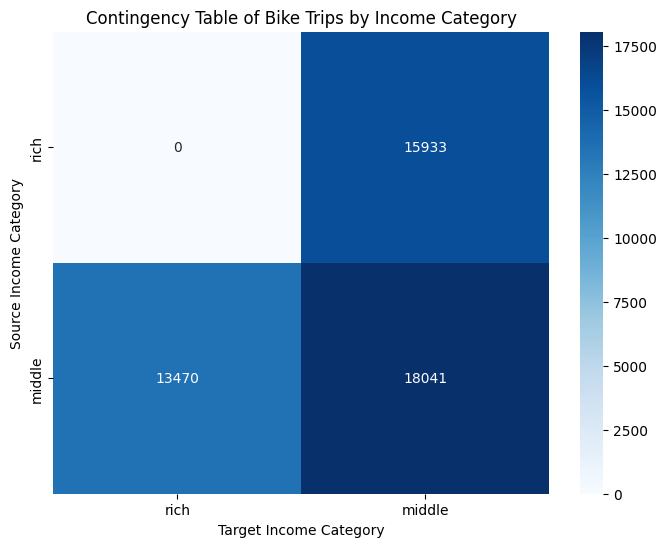

In [41]:
def aggregate_by_income_category(df, partition, community_classification):
    # Create an empty DataFrame for the contingency table
    contingency_table = pd.DataFrame(0, index=['rich', 'middle', 'poor'], columns=['rich', 'middle', 'poor'])
    
    for _, row in df.iterrows():
        source = row['source']
        target = row['target']
        
        if source not in partition or target not in partition:
            continue
        
        source_community = partition[source]
        target_community = partition[target]

        # If we want to use only inter-community trips, we can use the following code
        if source_community == target_community:
            continue
        
        source_income_category = community_classification.get(source_community, 'unknown')
        target_income_category = community_classification.get(target_community, 'unknown')
        
        if source_income_category in contingency_table.index and target_income_category in contingency_table.columns:
            contingency_table.loc[source_income_category, target_income_category] += 1
    
    # Ensure all categories are included
    contingency_table = contingency_table.reindex(index=['rich', 'middle', 'poor'], columns=['rich', 'middle', 'poor'], fill_value=0)
    
    # Remove rows and columns where all values are zero
    contingency_table = contingency_table.loc[(contingency_table.sum(axis=1) > 0), (contingency_table.sum(axis=0) > 0)]
    
    return contingency_table

def perform_chi_square_test(contingency_table):
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2, p, dof, expected

def analyze_income_influence_on_trips(df, G):
    # Convert the graph to undirected
    G_undirected = G.to_undirected()

    # Get the partition (community assignment) using the Louvain method
    partition = community_louvain.best_partition(G_undirected, randomize=False)
    
    # Create dictionaries to count the number of stations in each category for each community
    community_poor_count = {}
    community_middle_count = {}
    community_rich_count = {}
    community_total_count = {}

    for station, community in partition.items():
        if community not in community_poor_count:
            community_poor_count[community] = 0
            community_middle_count[community] = 0
            community_rich_count[community] = 0
            community_total_count[community] = 0

        if station in df['source'].values:
            source_category = df[df['source'] == station]['SourceIncomeCategory'].values[0]
            if source_category == 'poor':
                community_poor_count[community] += 1
            elif source_category == 'middle':
                community_middle_count[community] += 1
            elif source_category == 'rich':
                community_rich_count[community] += 1

            community_total_count[community] += 1

        if station in df['target'].values:
            target_category = df[df['target'] == station]['TargetIncomeCategory'].values[0]
            if target_category == 'poor':
                community_poor_count[community] += 1
            elif target_category == 'middle':
                community_middle_count[community] += 1
            elif target_category == 'rich':
                community_rich_count[community] += 1

            community_total_count[community] += 1

    # Calculate the percentage of each category in each community
    community_poor_percentage = {community: (community_poor_count[community] / community_total_count[community]) * 100
                                 for community in community_poor_count}
    community_middle_percentage = {community: (community_middle_count[community] / community_total_count[community]) * 100
                                   for community in community_middle_count}
    community_rich_percentage = {community: (community_rich_count[community] / community_total_count[community]) * 100
                                 for community in community_rich_count}

    # Classify each community by its dominant income category
    community_classification = {}
    for community in community_poor_percentage:
        percentages = {
            'poor': community_poor_percentage.get(community, 0),
            'middle': community_middle_percentage.get(community, 0),
            'rich': community_rich_percentage.get(community, 0)
        }
        dominant_category = max(percentages, key=percentages.get)
        community_classification[community] = dominant_category

    # Aggregate data and perform the Chi-Square test
    contingency_table_by_income = aggregate_by_income_category(df, partition, community_classification)
    
    if not contingency_table_by_income.empty:
        chi2, p, dof, expected = perform_chi_square_test(contingency_table_by_income)

        print("Chi-Square Statistic:", chi2)
        print("p-value:", p)
        print("Degrees of Freedom:", dof)
        print("Expected Frequencies:")
        print(expected)
    else:
        print("Contingency table is empty after filtering zeroes.")

    # Plotting the contingency table
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table_by_income, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Contingency Table of Bike Trips by Income Category')
    plt.xlabel('Target Income Category')
    plt.ylabel('Source Income Category')
    plt.show()

# Running the analysis on dfQ1 and GQ1
analyze_income_influence_on_trips(dfQ1_with_labels, GQ1)

As expected, the numbers changed. For example we can see that there are no rich-rich inter-community trips (because there's only one rich community)
The p-value didn't change and we still reject the null hypothesis.

Now let's try Q2's network.

Chi-Square Statistic: 9515.042181443952
p-value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[3.58827055e+03 5.96576791e+03 2.79615446e+01]
 [5.74789862e+03 9.55631096e+03 4.47904141e+01]
 [3.18308283e+01 5.29211305e+01 2.48041254e-01]]


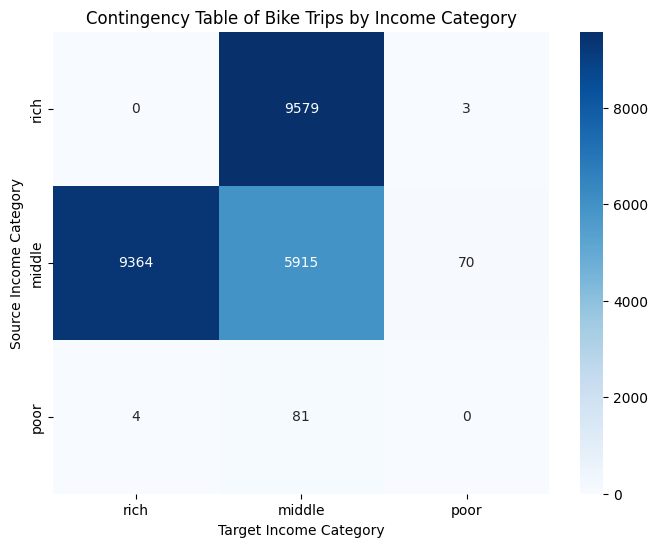

In [42]:
analyze_income_influence_on_trips(dfQ2_with_labels, GQ2)

The chi-squared test gave us same good results.

Now let's try Q3's network.

Chi-Square Statistic: 12648.759518274464
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[ 4635.5674086  7842.4325914]
 [ 6480.4325914 10963.5674086]]


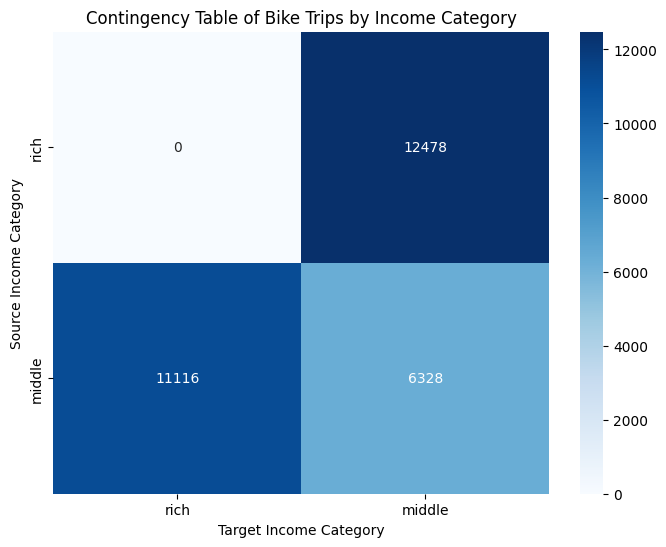

In [43]:
analyze_income_influence_on_trips(dfQ3_with_labels, GQ3)

Again, same results.

Now let's try Q4's network.

Chi-Square Statistic: 16530.114888245585
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[46925.4241802 35491.5758198]
 [32648.5758198 24693.4241802]]


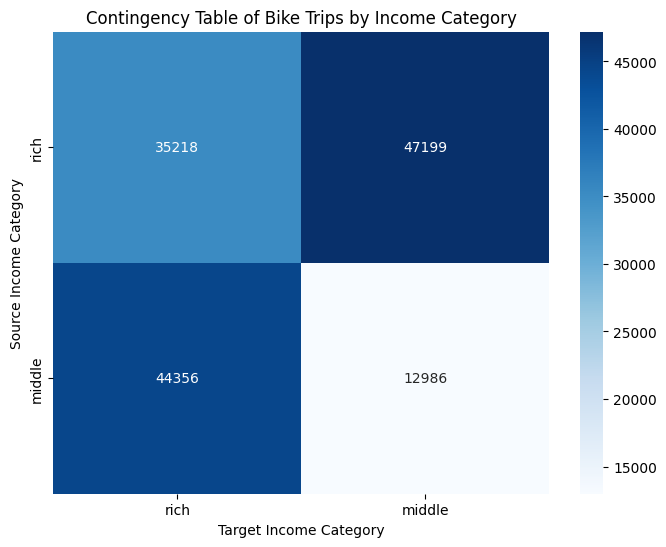

In [44]:
analyze_income_influence_on_trips(dfQ4_with_labels, GQ4)

As we can see, our test results are good again.

As the last test, let's check the complete network.

Chi-Square Statistic: 80139.25594752064
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[30444.08914329 55060.91085671]
 [43794.91085671 79207.08914329]]


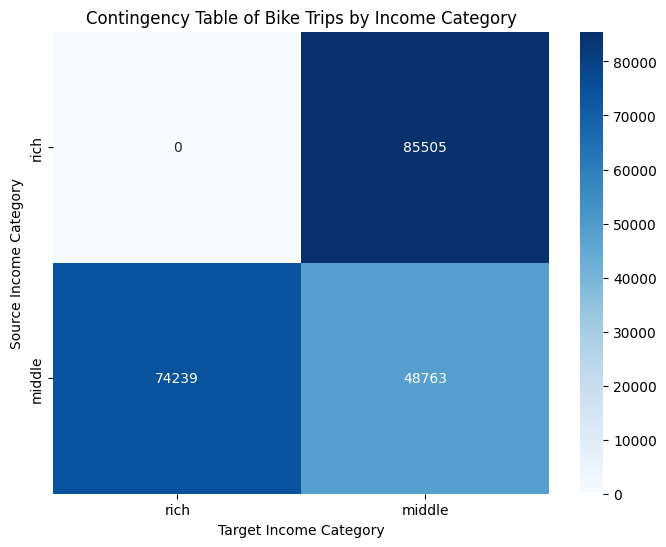

In [45]:
analyze_income_influence_on_trips(dfALL_with_labels, GALL)

Again, same good results.

All in all, we can see that the p-value is close to zero on all the chi-squared test we've done.
We can also see that in almost all contingency tables, there's a lot more same-income type trips or trips that atleast one of the sides is considered rich. Thus, we can conclude our second hypothesis to be true.

Now, we would like to check our third and last hypothesis which states that communities with a larger ratio of subscribers than regular customers have more trips and its subscribers are utilizing the pairs of stations better. This makes sense to us because people who pay more to be a subsciber probably drive more and thus also use more pairs of stations.

We'll start with Q1's network and do everything manually the first time. Then, we'll right a function to do everything for us for all other networks and use it to calcualte the results.

First, let's get the Louvain's partition again. (It was the best partition earlier so we'll use Louvain again)
Then, we'll get the percentage of subscribers vs regular customers in each community.

In [46]:
GQ1_undirected = GQ1.to_undirected()
partition = community_louvain.best_partition(GQ1_undirected, randomize=False)
dfQ1['start_community'] = dfQ1['source'].map(partition)
dfQ1['end_community'] = dfQ1['target'].map(partition)
start_community_trips = dfQ1.groupby('start_community')['USER TYPE'].value_counts(normalize=True).unstack().fillna(0)
end_community_trips = dfQ1.groupby('end_community')['USER TYPE'].value_counts(normalize=True).unstack().fillna(0)
start_community_subscriber_percent = start_community_trips.get('Subscriber', 0) * 100
end_community_subscriber_percent = end_community_trips.get('Subscriber', 0) * 100
community_subscriber_percent = (start_community_subscriber_percent + end_community_subscriber_percent) / 2
community_subscriber_percent.name = 'Communities Subscribers Percentage'
community_subscriber_percent.index.name = 'Community To Subscribers Percentage'
community_subscriber_percent

Community To Subscribers Percentage
0    32.929353
1    53.173556
2    40.618853
3    16.308559
4    20.862090
Name: Communities Subscribers Percentage, dtype: float64

Now let's see a bar chart of the subscriber percentage trips in each community.

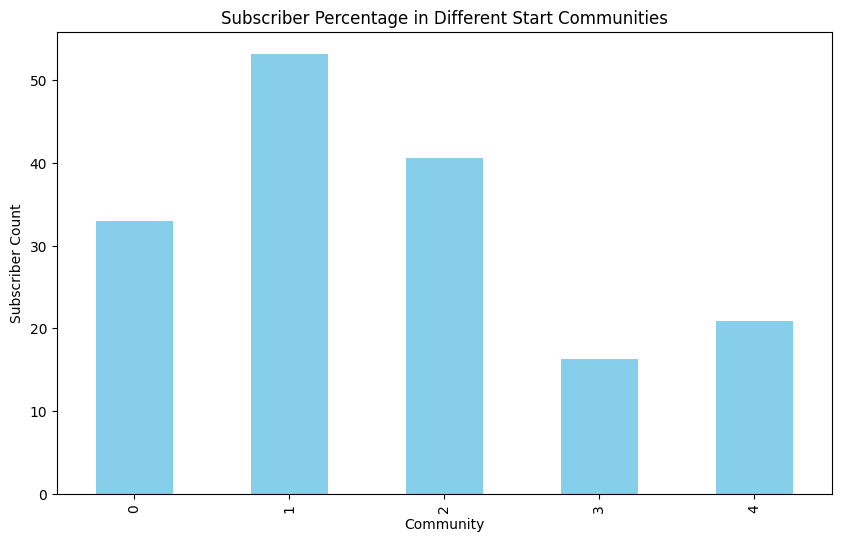

In [47]:
plt.figure(figsize=(10, 6))
community_subscriber_percent.plot(kind='bar', color='skyblue')
plt.title('Subscriber Percentage in Different Start Communities')
plt.xlabel('Community')
plt.ylabel('Subscriber Count')
plt.xticks(ticks=range(len(community_subscriber_percent)), labels=community_subscriber_percent.index)
plt.show()

Now let's see calculate and see the density of each community to later determine whether there's any connection between the subscribers percentage in each community to its density.

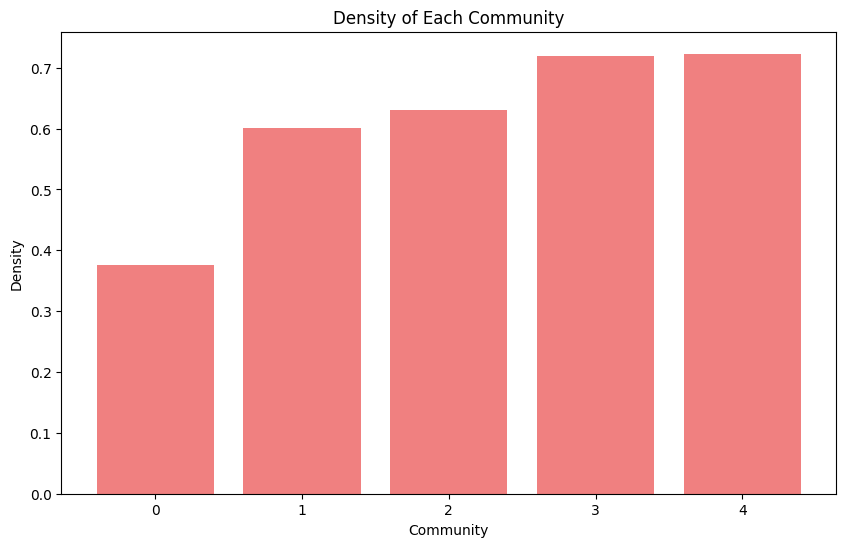

In [48]:
# Group nodes by community
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

# Calculate the density of each community
community_densities = {}
for community, nodes in communities.items():
    subgraph = GQ1.subgraph(nodes)
    density = nx.density(subgraph)
    community_densities[community] = density

plt.figure(figsize=(10, 6))
plt.bar(community_densities.keys(), community_densities.values(), color='lightcoral')
plt.title('Density of Each Community')
plt.xlabel('Community')
plt.ylabel('Density')
plt.xticks(ticks=range(len(community_densities)), labels=community_densities.keys())
plt.show()

Now let's calculate and print the total number of trips in each community.
Note: The total number of trips for a community X is a sum of the number of trips that X is in atleast one of the stations (start or end)

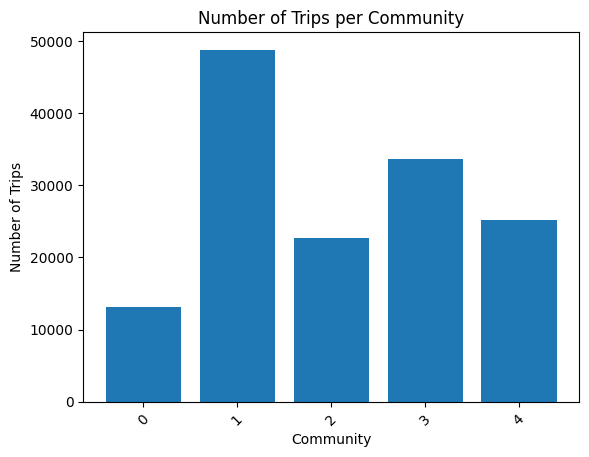

In [49]:
trips_per_community = {community: 0 for community in communities.keys()}
for _, row in dfQ1.iterrows():
    start_community = row['start_community']
    end_community = row['end_community']
    if start_community == end_community:
        trips_per_community[start_community] += 1
    else:
        trips_per_community[start_community] += 1
        trips_per_community[end_community] += 1
# Create the bar chart
plt.bar(trips_per_community.keys(), trips_per_community.values())

# Set the title and labels
plt.title('Number of Trips per Community')
plt.xlabel('Community')
plt.ylabel('Number of Trips')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.show()

Now let's see the correlation between the total number of trips to the percentage of subscribers in the communities and the density of the community to the percentage of subscribers in it.

In [50]:
trips_per_community_series = pd.Series(trips_per_community, name='Trips Per Community')
density_per_community_series = pd.Series(community_densities, name='Density Per Community')
correlationTrips = trips_per_community_series.corr(community_subscriber_percent)
correlationDensity = density_per_community_series.corr(community_subscriber_percent)
print('Correlation of density and subscribers percentage per community:', correlationDensity)
print('Correlation of number of trips and subscribers percentage per community:', correlationTrips)

Correlation of density and subscribers percentage per community: -0.3801933036049857
Correlation of number of trips and subscribers percentage per community: 0.40087003177719466


As we can see, there isn't a correlation that we expected between the percentage of subscribers and its density value. We wanted to see a positive correlation but got got a negative value.
There's a moderate positive correlation between the subscribers percentage and the community total degree value.
We currently don't have enough data to reject/accept the hypothesis so let's write a function to do it all for us and use it to test the other quarter's results.

The function will use Louvain's partition to get the graph's communities, plot all the data we calcualted in bar charts, and calculate the correlations.

In [51]:
def ThirdHypothesisTesting(G, df):
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected, randomize=False)
    df['start_community'] = df['source'].map(partition)
    df['end_community'] = df['target'].map(partition)
    start_community_trips = df.groupby('start_community')['USER TYPE'].value_counts(normalize=True).unstack().fillna(0)
    end_community_trips = df.groupby('end_community')['USER TYPE'].value_counts(normalize=True).unstack().fillna(0)
    start_community_subscriber_percent = start_community_trips.get('Subscriber', 0) * 100
    end_community_subscriber_percent = end_community_trips.get('Subscriber', 0) * 100
    community_subscriber_percent = (start_community_subscriber_percent + end_community_subscriber_percent) / 2
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    # Calculate the density of each community
    community_densities = {}
    for community, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        density = nx.density(subgraph)
        community_densities[community] = density

    # Calculate the number of trips in each community
    trips_per_community = {community: 0 for community in communities.keys()}

    for _, row in df.iterrows():
        start_community = row['start_community']
        end_community = row['end_community']
        if start_community == end_community:
            trips_per_community[start_community] += 1
        else:
            trips_per_community[start_community] += 1
            trips_per_community[end_community] += 1

    # Plotting the data
    fig, axes = plt.subplots(1, 3, figsize=(25, 10))

    # Subscriber Percent of each community
    axes[0].bar(community_subscriber_percent.index, community_subscriber_percent.values, color='gold')
    axes[0].set_title('Subscriber Percent of Each Community')
    axes[0].set_xlabel('Community')
    axes[0].set_ylabel('Subscriber Percent')
    axes[0].set_xticks(ticks=range(len(community_subscriber_percent)))
    axes[0].set_xticklabels(community_subscriber_percent.index)

    # Number of Trips per Community
    axes[1].bar(trips_per_community.keys(), trips_per_community.values(), color='plum')
    axes[1].set_title('Number of Trips per Community')
    axes[1].set_xlabel('Community')
    axes[1].set_ylabel('Number of Trips')
    axes[1].set_xticks(ticks=range(len(trips_per_community)))
    axes[1].set_xticklabels(trips_per_community.keys())

    # Density of each community
    axes[2].bar(community_densities.keys(), community_densities.values(), color='lightcoral')
    axes[2].set_title('Density of Each Community')
    axes[2].set_xlabel('Community')
    axes[2].set_ylabel('Density')
    axes[2].set_xticks(ticks=range(len(community_densities)))
    axes[2].set_xticklabels(community_densities.keys())

    plt.tight_layout()
    plt.show()

    density_per_community_series = pd.Series(community_densities, name='Density Per Community')
    trips_per_community_series = pd.Series(trips_per_community, name='Trips Per Community')
    correlationDensity = density_per_community_series.corr(community_subscriber_percent)
    correlationTrips = trips_per_community_series.corr(community_subscriber_percent)
    print('Correlation of density and subscribers percentage per community:', correlationDensity)
    print('Correlation of number of trips and subscribers percentage per community:', correlationTrips)

Now let's use this function to get the results for Q2's network

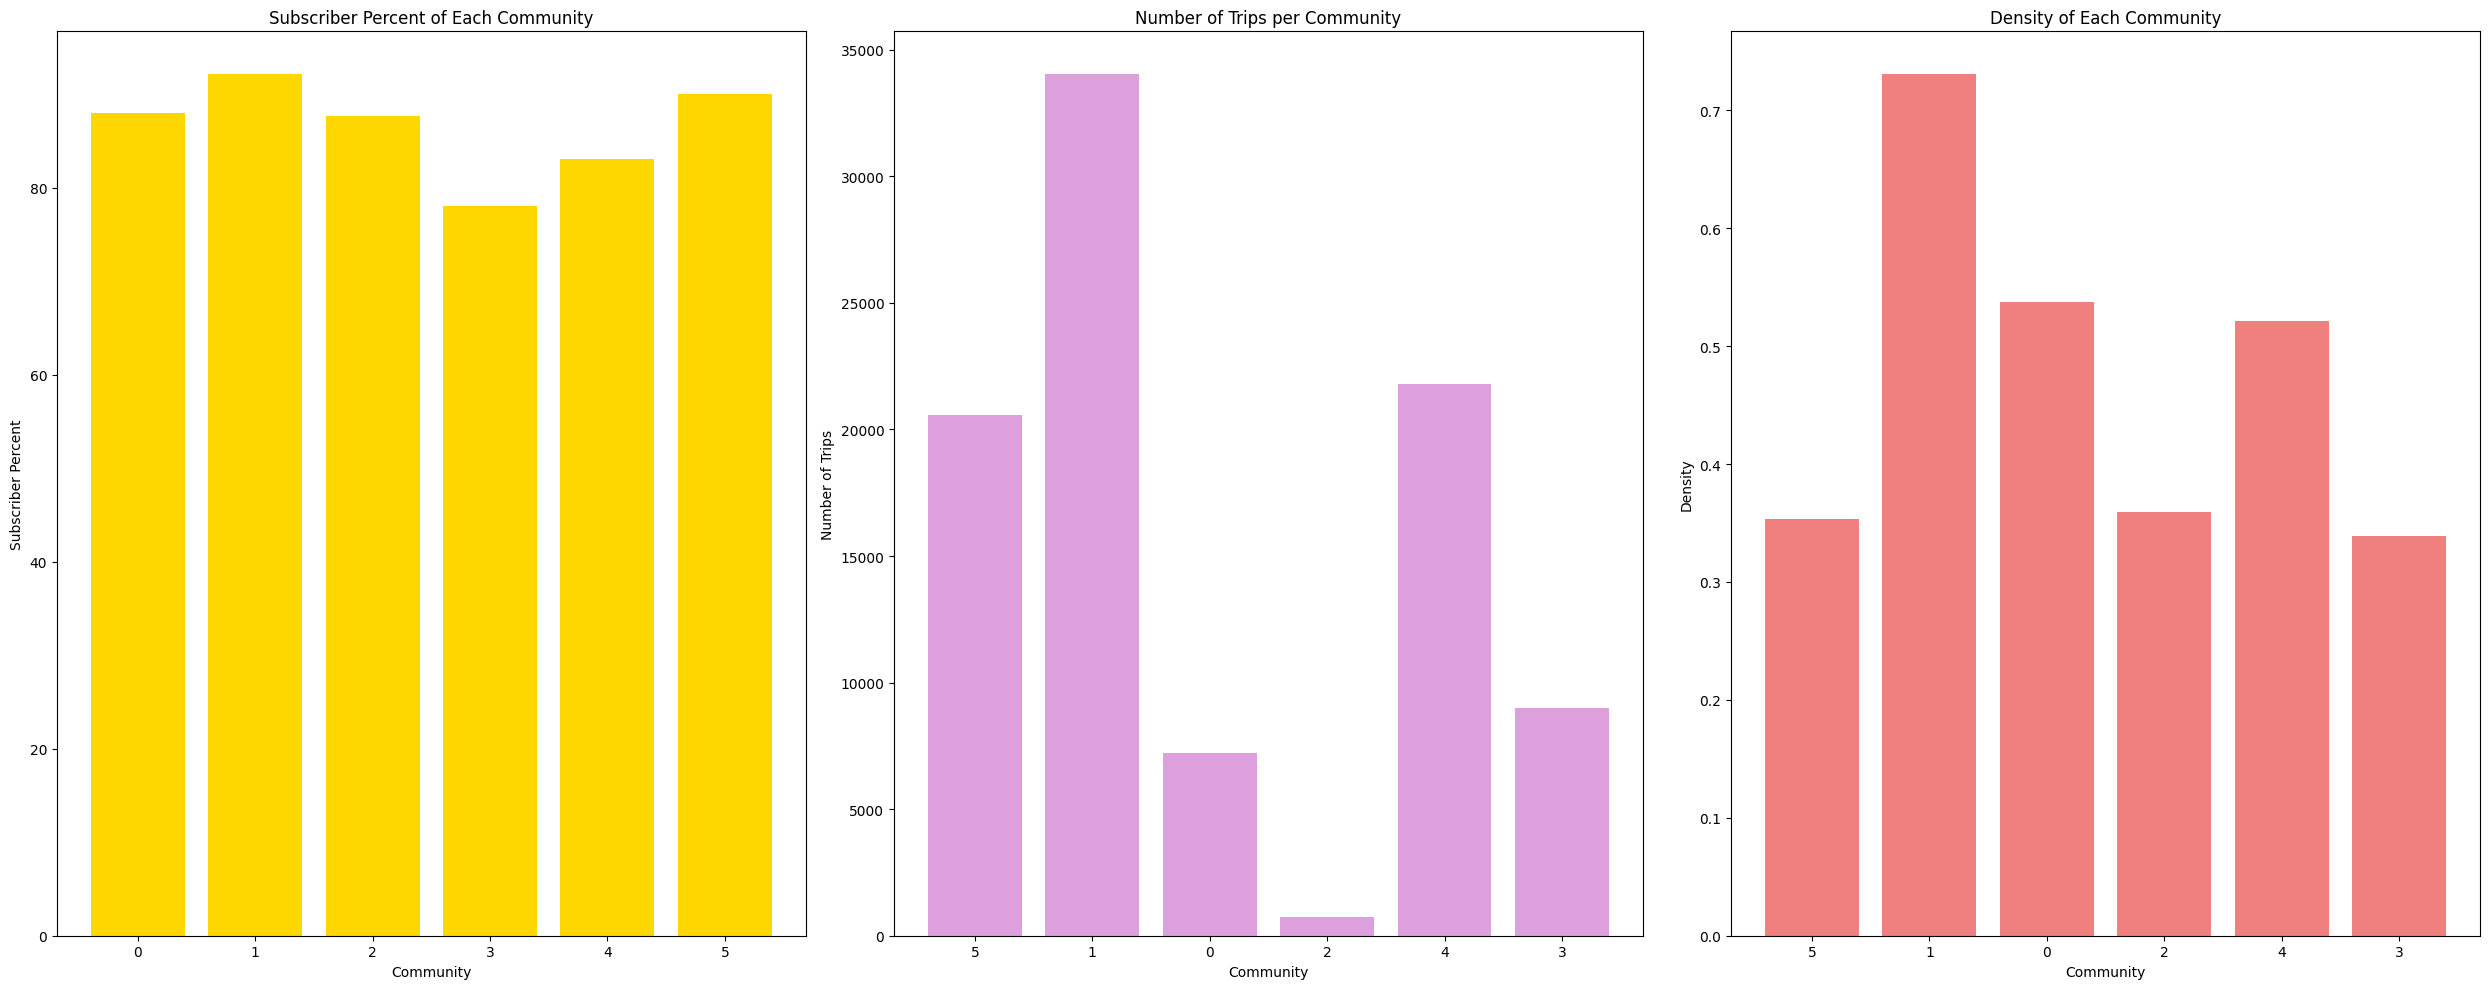

Correlation of density and subscribers percentage per community: 0.42127462564112234
Correlation of number of trips and subscribers percentage per community: 0.5857797688155187


In [52]:
ThirdHypothesisTesting(GQ2, dfQ2)

As we can see, there's a moderate positive correlation which is good for us.

Now let's see the results for Q3.

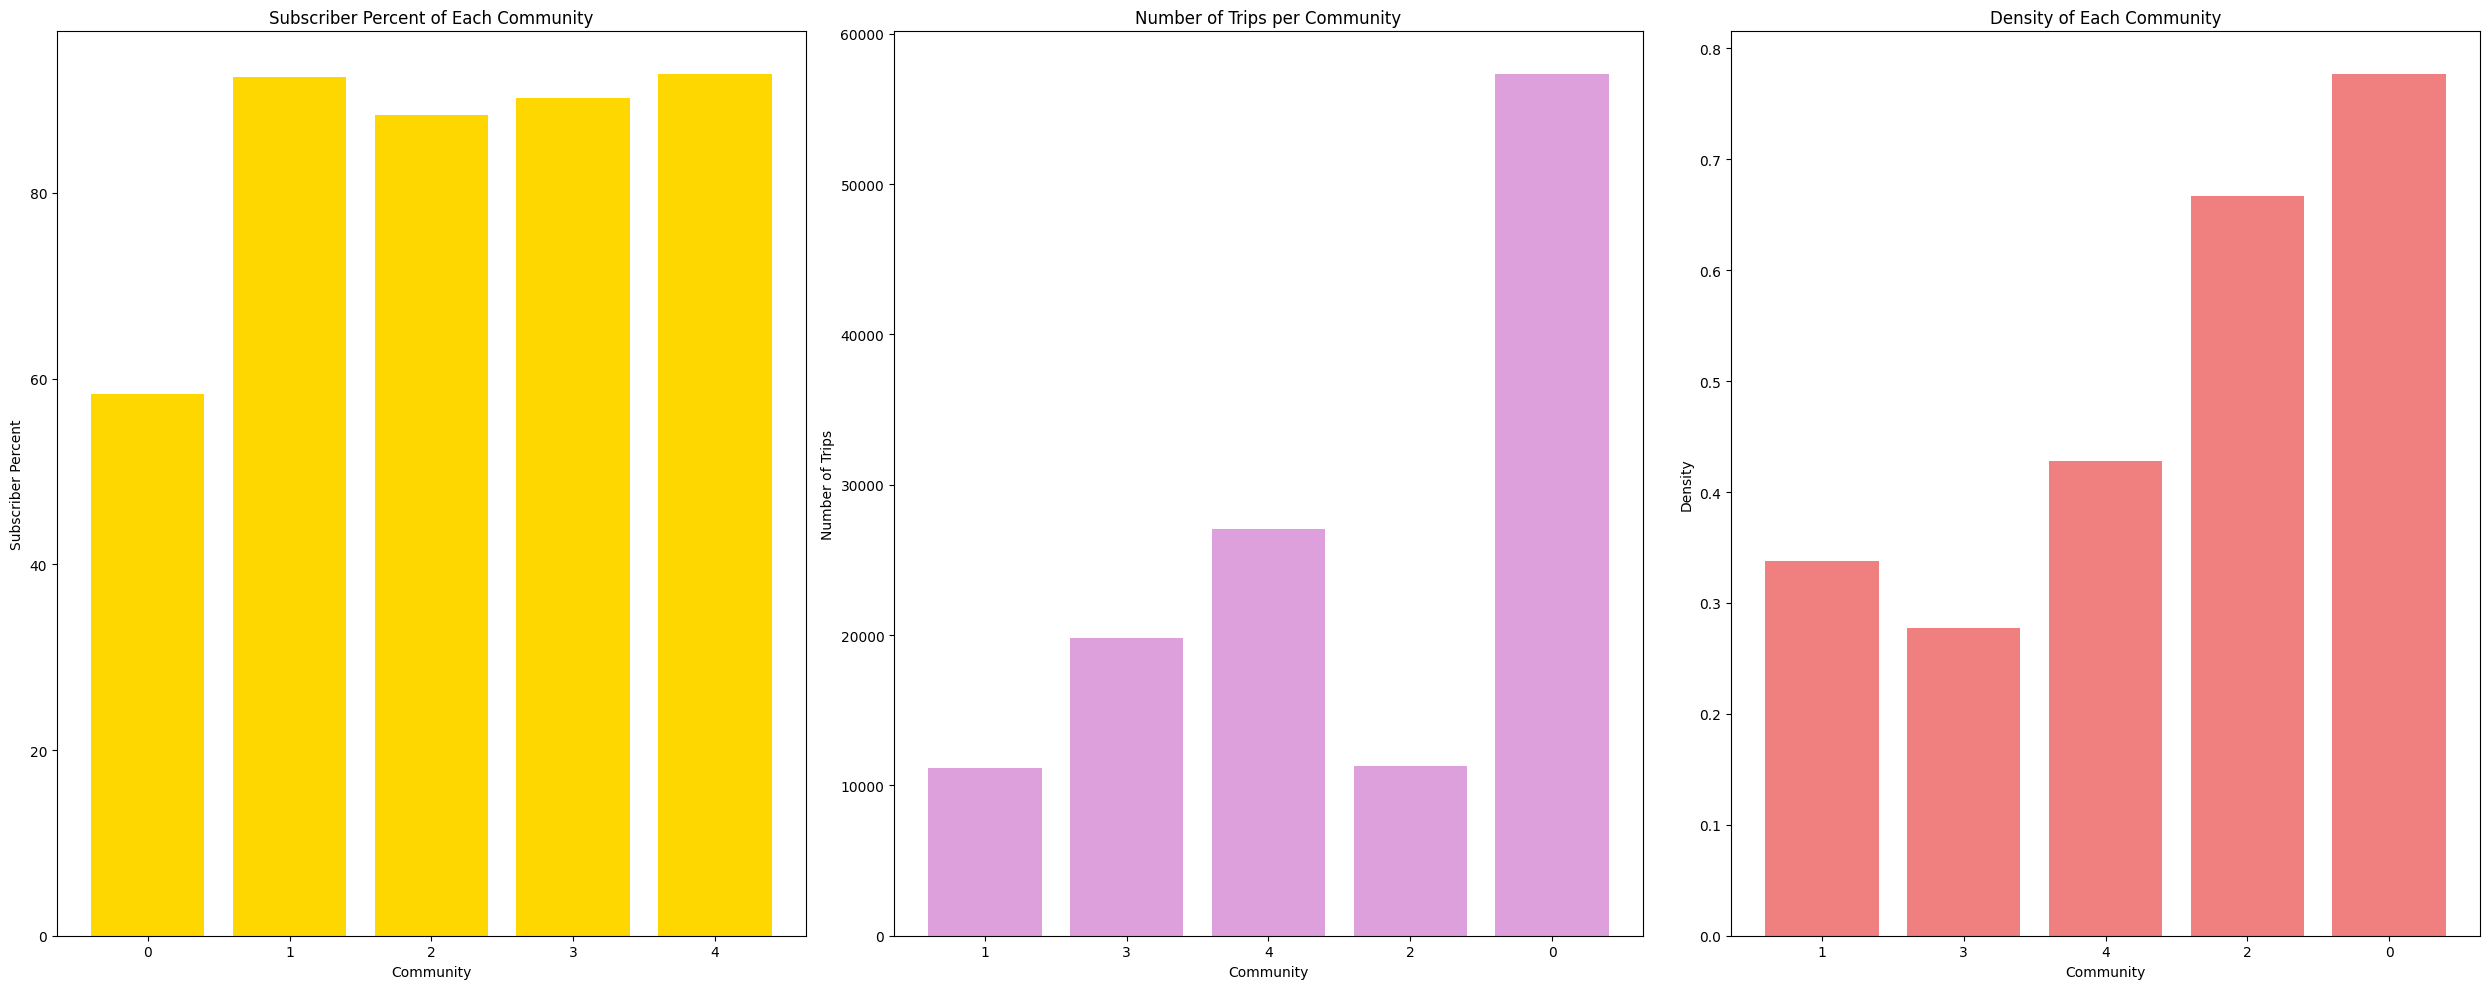

Correlation of density and subscribers percentage per community: 0.42947022512523036
Correlation of number of trips and subscribers percentage per community: 0.4628369982816772


In [53]:
ThirdHypothesisTesting(GQ3, dfQ3)

Again, we got positive moderate correlation for all values.

Now let's see the results for Q4.

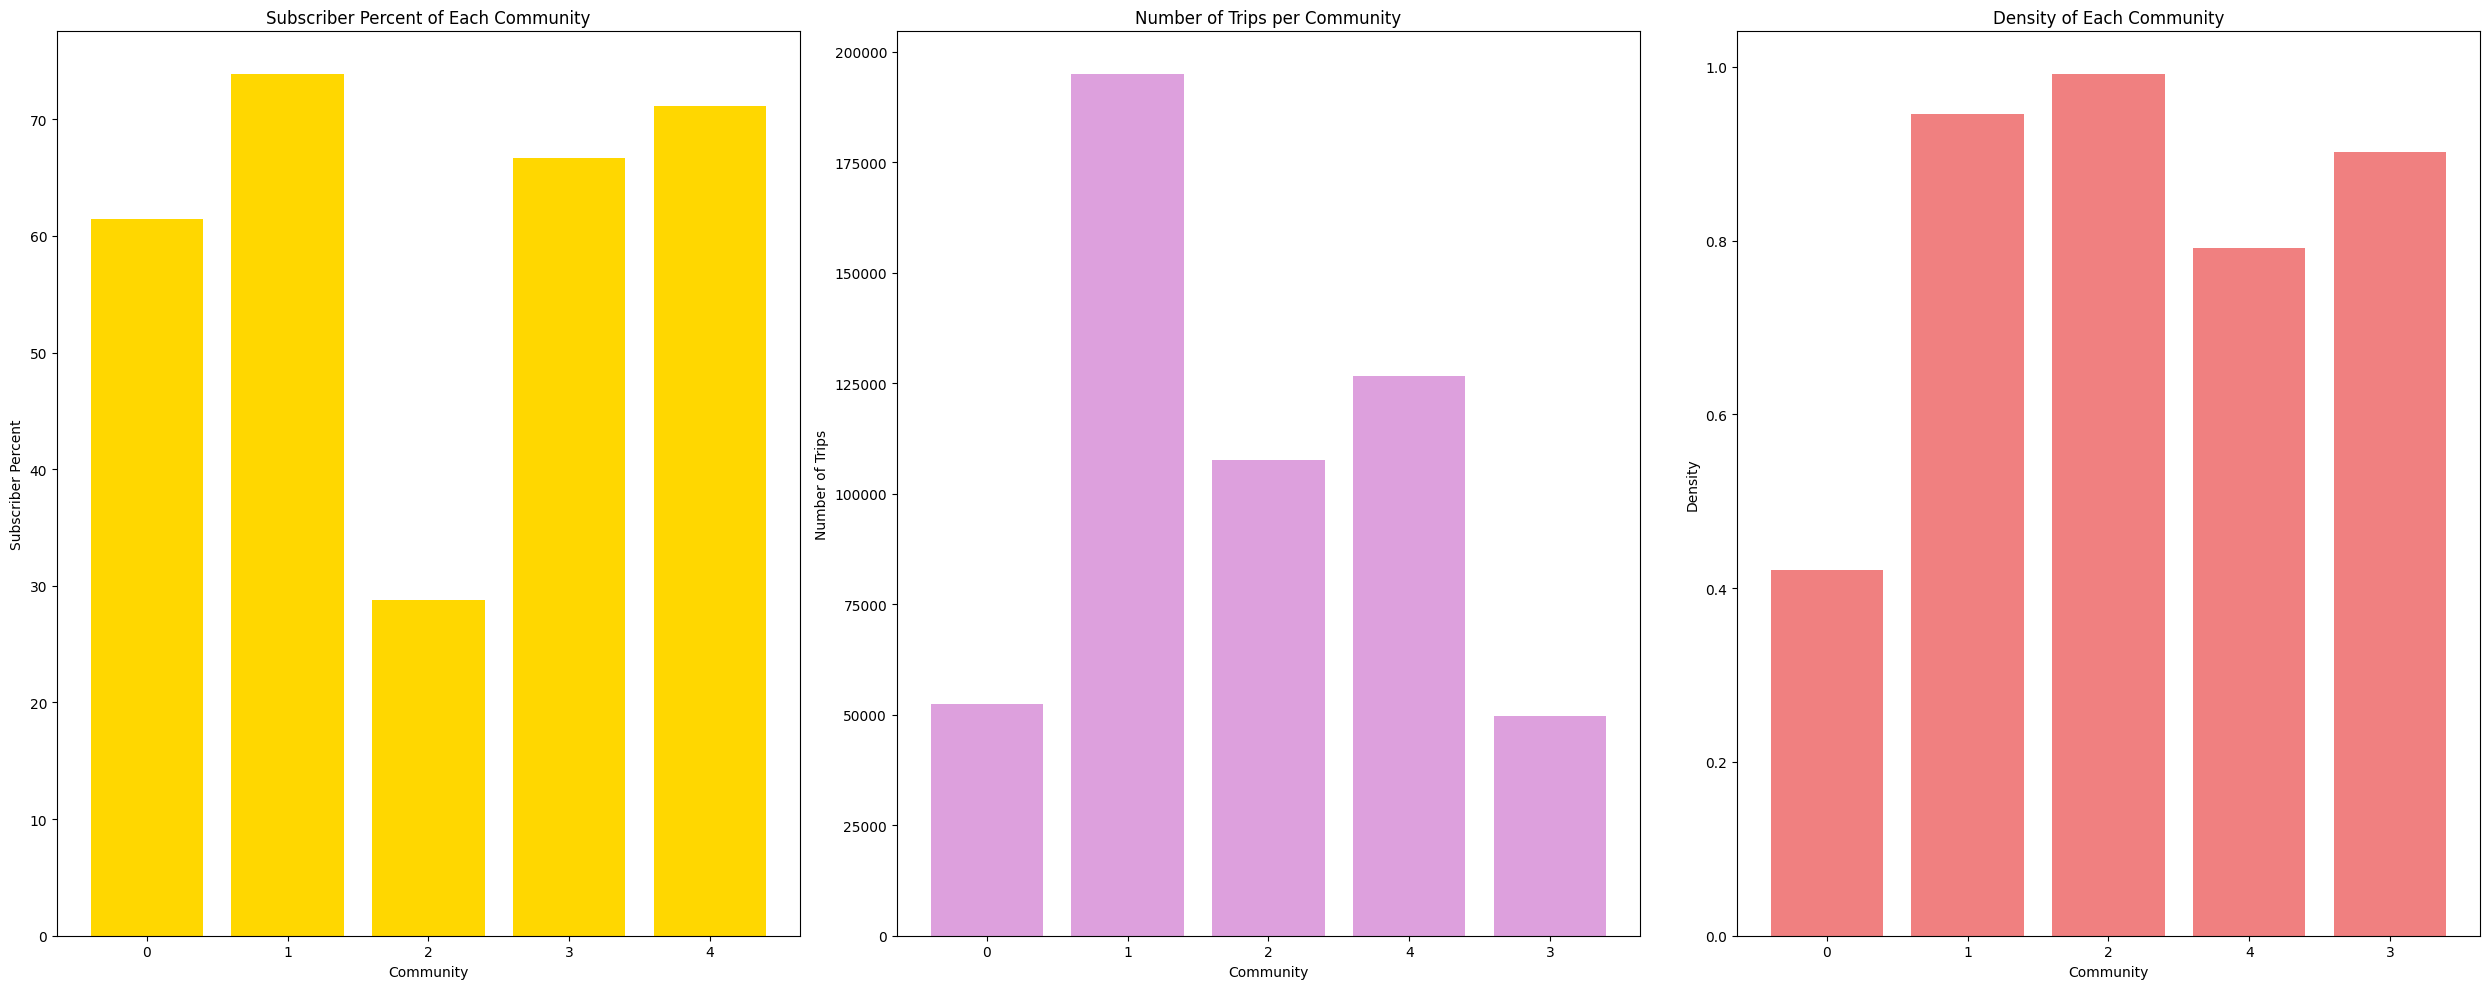

Correlation of density and subscribers percentage per community: -0.2043021567439861
Correlation of number of trips and subscribers percentage per community: 0.1393548778418302


In [54]:
ThirdHypothesisTesting(GQ4, dfQ4)

Now we got bad correlation values for both subscribers % and density, and subscribers % and number of trips.

To wrap it all up, let's see the results for the complete network.

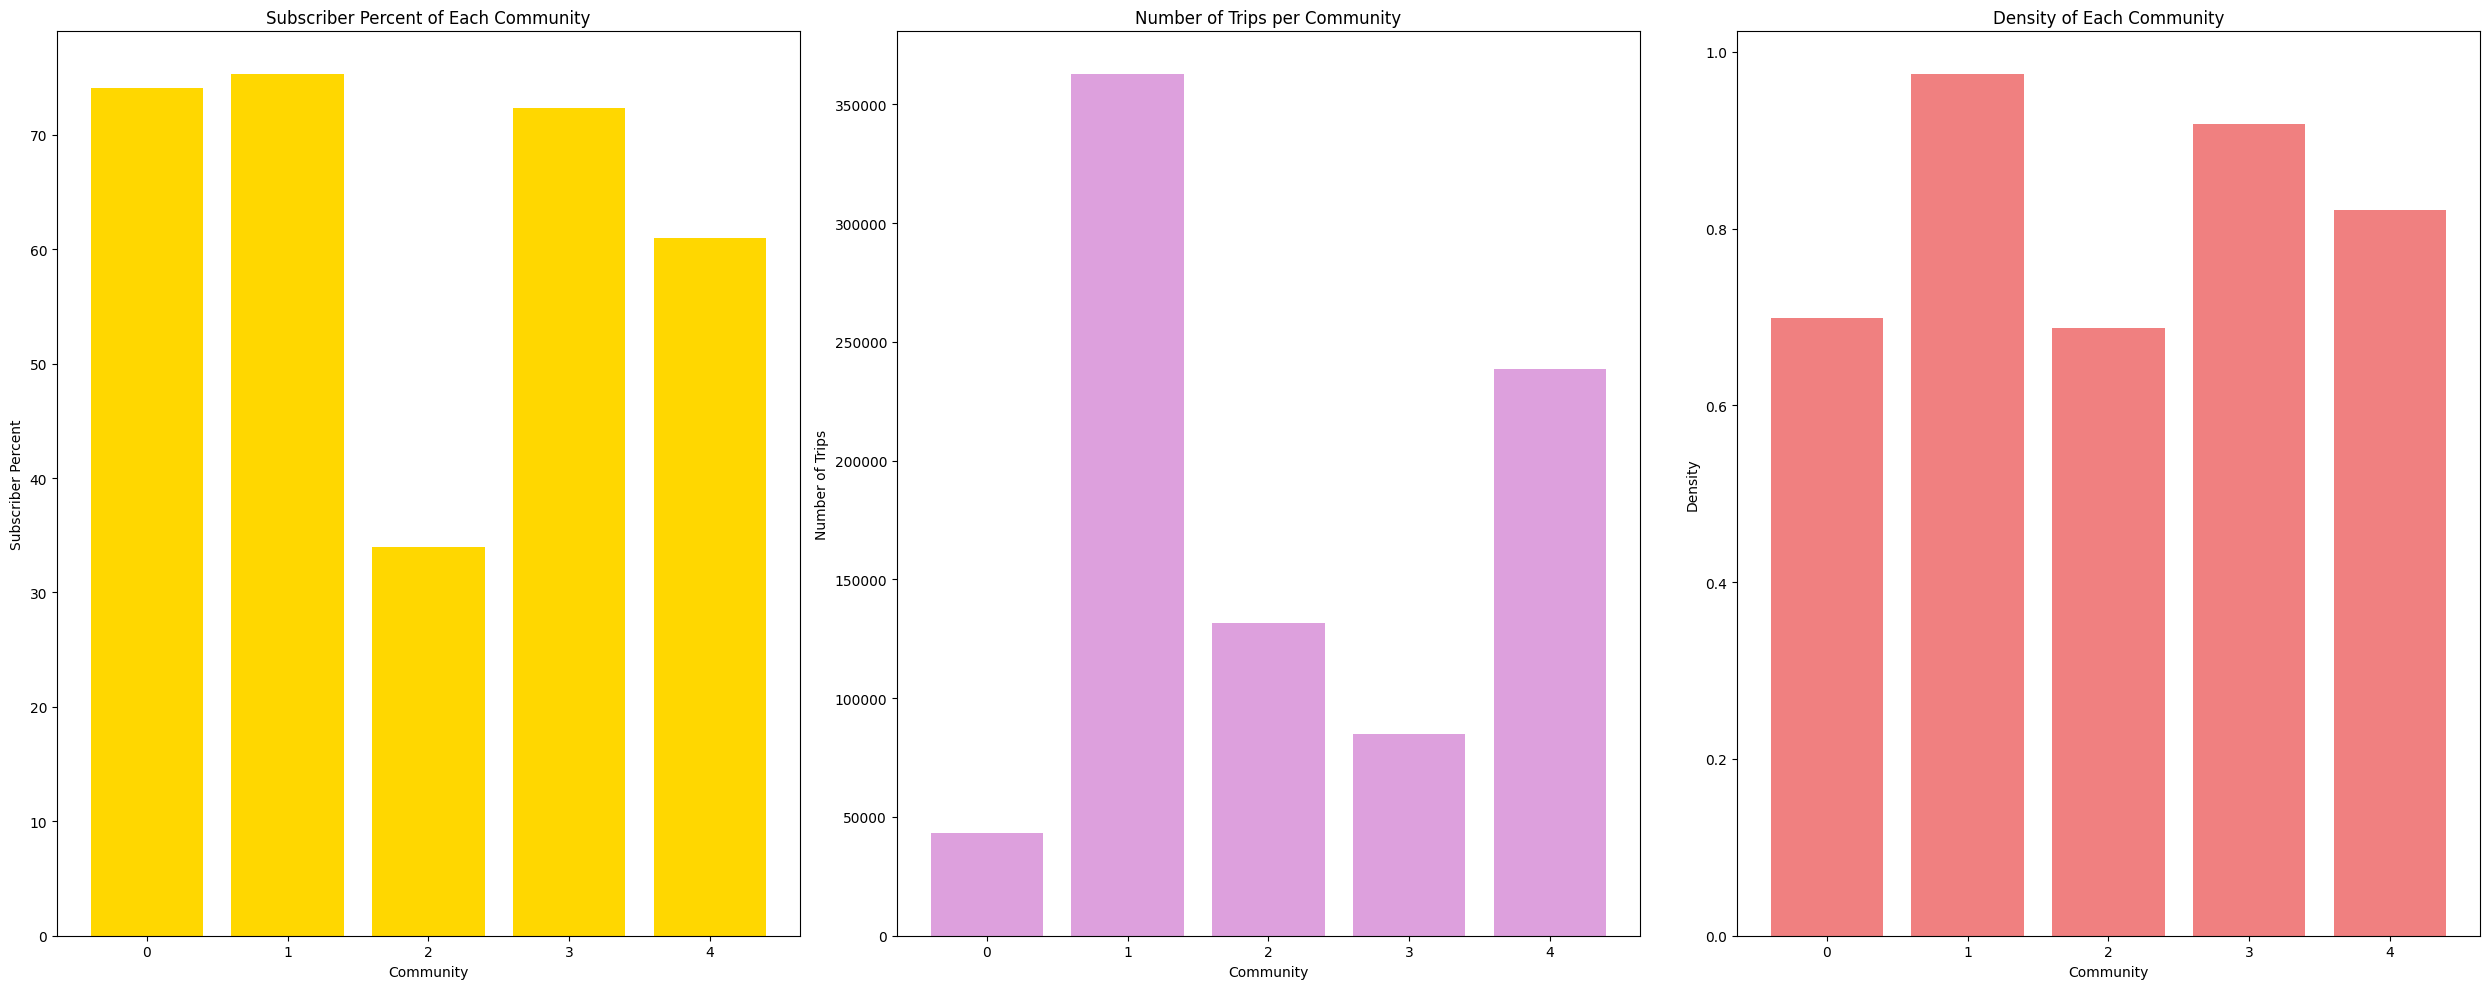

Correlation of density and subscribers percentage per community: 0.597098507445348
Correlation of number of trips and subscribers percentage per community: 0.12698947646916153


In [55]:
ThirdHypothesisTesting(GALL, dfAll)

Again, we got a positive moderate correlation value. The total degree to subscribers percentage correlation is considered weak.

Now let's plot the correlation's results.

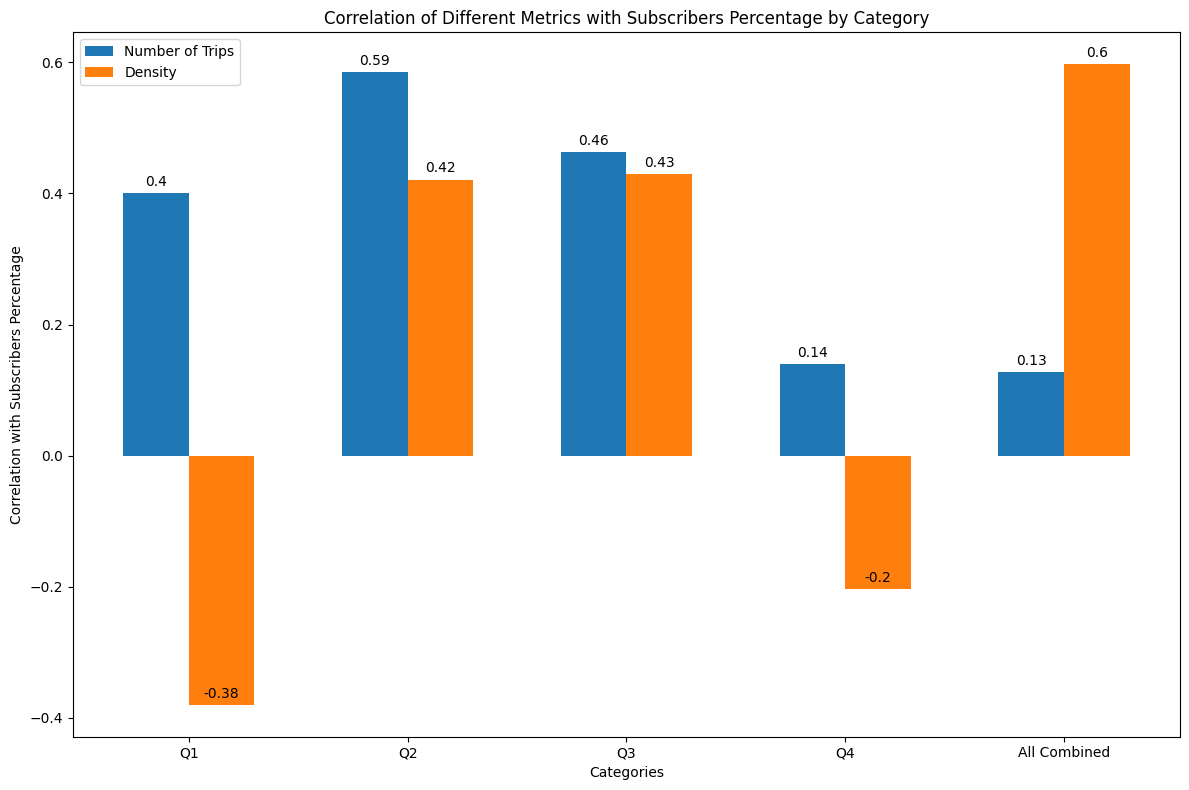

In [56]:
data = {
    "Q1": {
        "number_of_trips": 0.40087003177719466,
        "density": -0.3801933036049857
    },
    "Q2": {
        "density": 0.42127462564112234,
        "number_of_trips": 0.5857797688155187
    },
    "Q3": {
        "density": 0.42947022512523036,
        "number_of_trips": 0.4628369982816772
    },
    "Q4": {
        "density": -0.2043021567439861,
        "number_of_trips": 0.1393548778418302
    },
    "All Combined": {
        "density": 0.597098507445348,
        "number_of_trips": 0.12698947646916153
    }
}

# Extract data for plotting
categories = list(data.keys())
number_of_trips = [data[cat].get('number_of_trips', 0) for cat in categories]
density = [data[cat].get('density', 0) for cat in categories]

# Plotting
x = np.arange(len(categories))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, number_of_trips, width, label='Number of Trips')
rects2 = ax.bar(x + width/2, density, width, label='Density')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Categories')
ax.set_ylabel('Correlation with Subscribers Percentage')
ax.set_title('Correlation of Different Metrics with Subscribers Percentage by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In this chart it's very easy to see that there's isn't enough evidence to conclude that there's correlation between the subscribers percentage and all the other values except total degree. It does look like there's a positive moderate correlation between the subscribers percentage and total degree.

Now we know that communities with a larger ratio of subscribers than regular customers are not utilizing the pairs of stations better, and they don't drive more than regular customers, regarding paying the company more money (usually!).

In conclusion: We built some networks, found out that they are small-world networks, found out that stations that are closer to central places (Universities, big train stations, tourist attractions, etc.) in the city are central stations in the network. We also found out that there's a difference in trips of different income type communities. Then, we couldn't find enough evidence to support our third hypothesis that communities with a larger ratio of subscribers than regular customers are not utilizing the pairs of stations better but we did see a trend that looks like subscribers drive more and they use the network more often.

We've had a lot of fun working on this research project.
Thank you very much!